In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score # AUC score
from sklearn.metrics import average_precision_score # AUPR score
from sklearn.metrics import precision_recall_fscore_support # precision, recall
from imblearn.metrics import sensitivity_specificity_support # sensitivity, specificity
from sklearn.metrics import roc_curve # to draw auc curve
from sklearn.metrics import precision_recall_curve # to draw aupr curve
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
tn = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/PREDICT_data/3_2_tn_local_descriptor_predict.tsv")

In [4]:
no_tn = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/PREDICT_data/3_2_2_noTN_local_descriptor_predict.tsv")

In [248]:
whole = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/PREDICT_data/2_1_gold_descriptor_combined.tsv")

In [13]:
#PREDICT independent dataset
indep = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/PREDICT_data/2_2_indep_descriptor.tsv")
indep_x = indep.values[:, 3:].astype(float)
indep_y = indep.values[:,2].astype(int)

In [25]:
tn_neg_count = len(tn[tn.association == 0])
print tn_neg_count
tn.head(1)

12887


,drug_id,disease_id,association,C0000727,C0000731,C0000737,C0000768,C0000772,C0000786,C0000814,...,387585,388165,55219,55973,65264,80350,84624,84722,91851,406216
0,DB00659,103780,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
no_tn_count = len(no_tn)
print len(no_tn)
no_tn.head(1)

88897


,drug_id,disease_id,association,C0000727,C0000731,C0000737,C0000768,C0000772,C0000786,C0000814,...,387585,388165,55219,55973,65264,80350,84624,84722,91851,406216
0,DB00659,608622,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# FP 구하기
df_predicted_result = pd.DataFrame({'Drug_id':indep['drug_id'],'Disease_id':indep['disease_id'],
                                    'Predicted_label' : fp_results['Predicted_label'],
                                    'Predicted_proba' : fp_results['predicted_proba'][:,1], 
                                    'y_true':fp_results['y_true']})
df_fp = df_predicted_result[(df_predicted_result.Predicted_label != df_predicted_result.y_true) & 
                            (df_predicted_result.Predicted_label == 1)]#.sort_values('Predicted_proba')
print len(df_predicted_result), len(df_fp)
print folds_results['confusion_matrix']

In [71]:
def predicted_results(fp_results):
    df_predicted_result = pd.DataFrame({'Drug_id':indep['drug_id'],'Disease_id':indep['disease_id'],
                                    'Predicted_label' : fp_results['Predicted_label'],
                                    'Predicted_proba' : fp_results['predicted_proba'][:,1], 
                                    'y_true':fp_results['y_true']})
    return df_predicted_result

2017-04-04 21:55:14
0 : 500------------------------------------


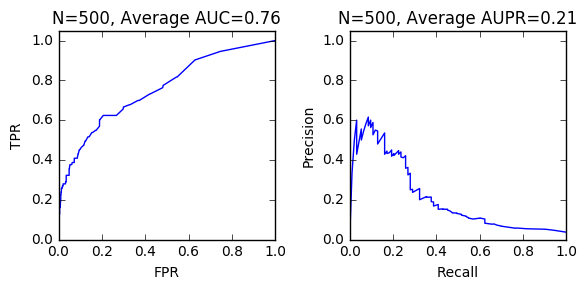

1 : 500------------------------------------


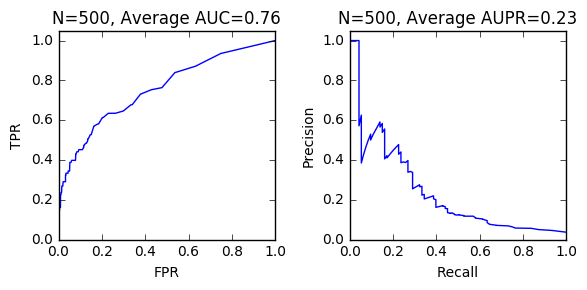

2 : 500------------------------------------


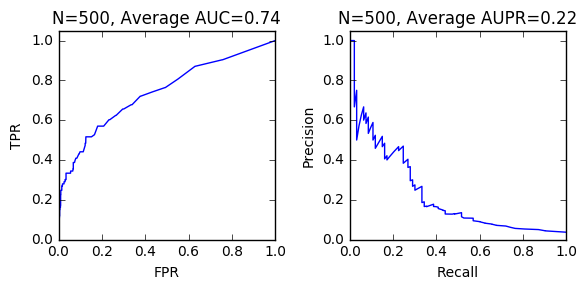

3 : 500------------------------------------


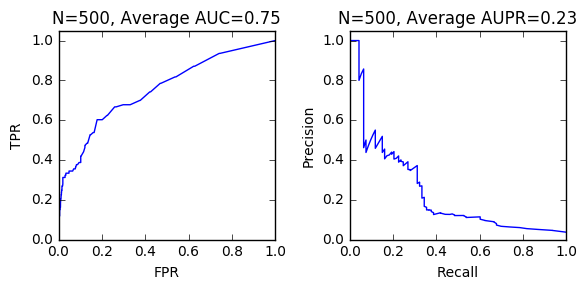

4 : 500------------------------------------


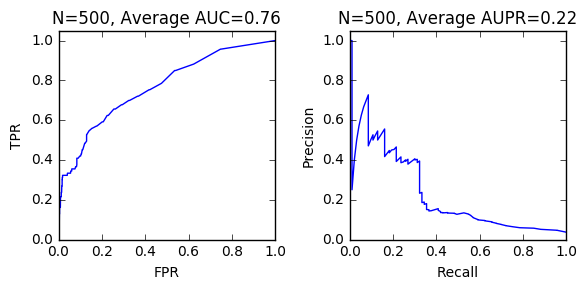

5 : 500------------------------------------


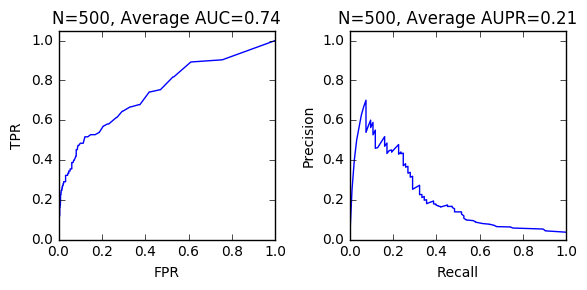

6 : 500------------------------------------


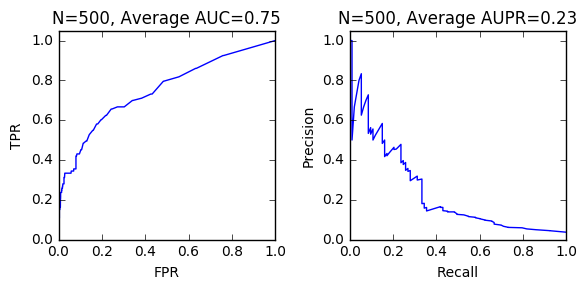

7 : 500------------------------------------


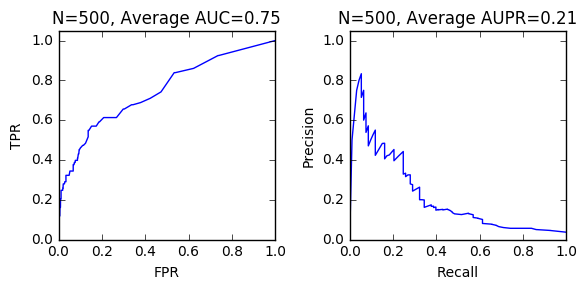

8 : 500------------------------------------


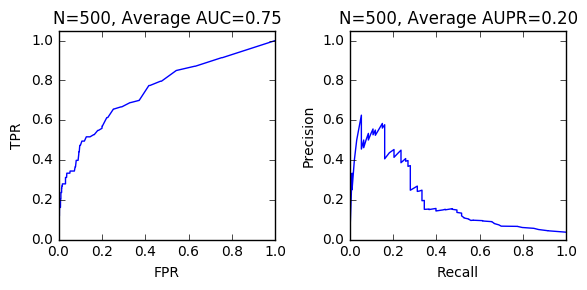

9 : 500------------------------------------


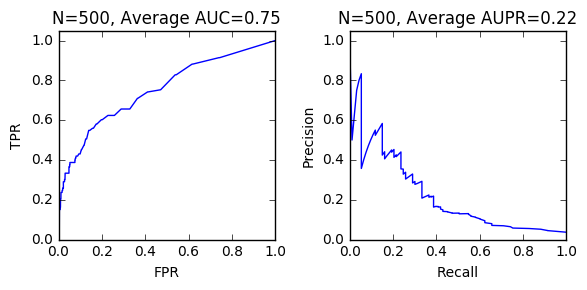

2017-04-04 22:01:22


In [118]:
# only noise -> noise 통채로
li_noises_wh = list()
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/'
with open(path + "0_RF_noise_only_indep.txt", 'w') as fd :
    user_estimator = 500
    noise_wh = pd.concat([tn[tn.association == 1],no_tn])
    for i in range(10):
        fd.write("<{} : independent>\r\n".format(i))
        
        x_whole_data = noise_wh[noise_wh.columns.values[3:].tolist()].values
        y_whole_data = noise_wh["association"].values

        folds_results, draw_results, fp_results = Random_Forest_independent_graph(x_whole_data, y_whole_data, indep_x, indep_y, user_estimator)
        li_noises_wh.append(predicted_results(fp_results))
        draw_plot([draw_results], folds_results, i, user_estimator)
        write_output(fd, folds_results, i, user_estimator)
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df_predicted_results_noise_wh = pd.concat(li_noises_wh)

2017-04-04 22:01:22
0 : 500------------------------------------


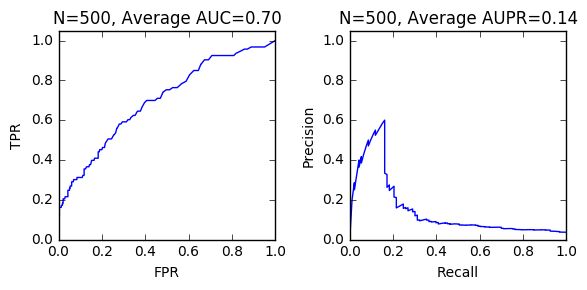

1 : 500------------------------------------


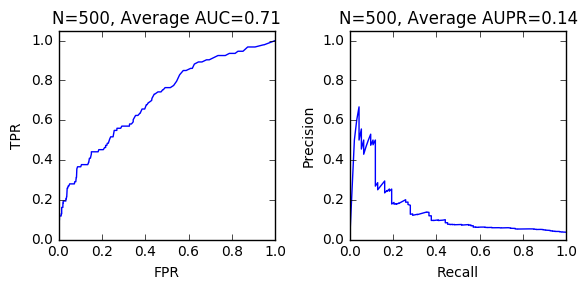

2 : 500------------------------------------


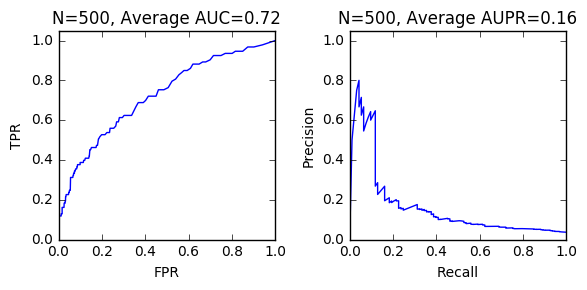

3 : 500------------------------------------


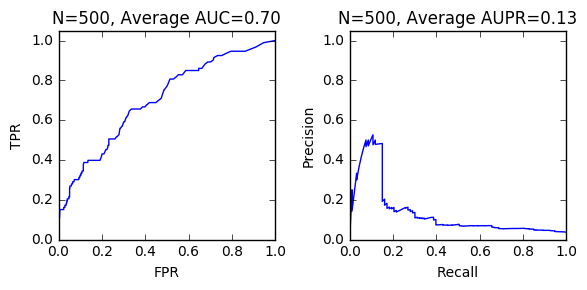

4 : 500------------------------------------


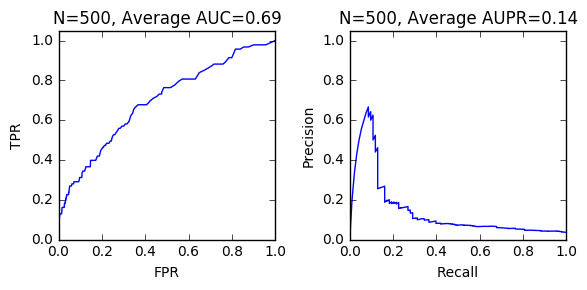

5 : 500------------------------------------


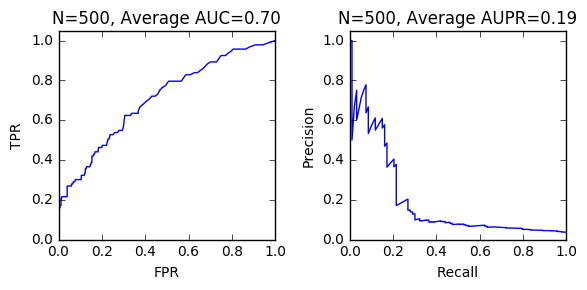

6 : 500------------------------------------


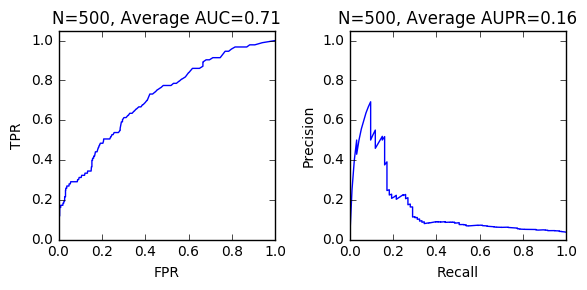

7 : 500------------------------------------


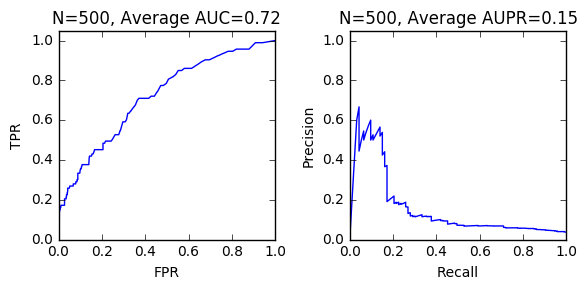

8 : 500------------------------------------


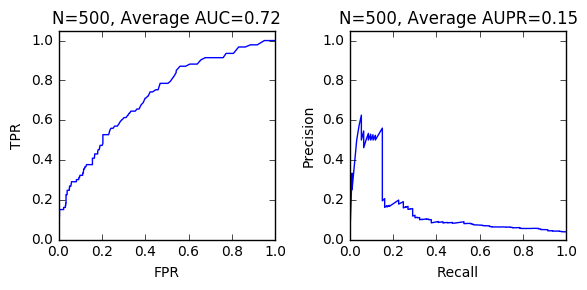

9 : 500------------------------------------


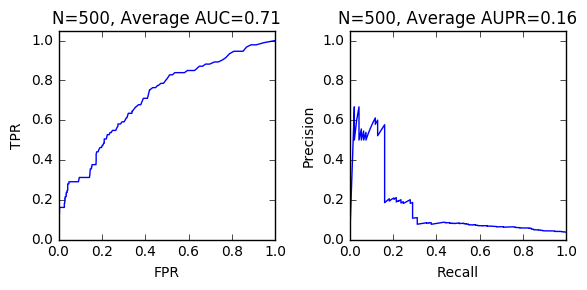

2017-04-04 22:03:58


In [119]:
# only noise --> random pick
noise_indices = list()
li_noises = list()
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/'
with open(path + "0_RF_noise_only(random_pick)_indep.txt", 'w') as fd :
    user_estimator = 500
    for i in range(10):
    #for idx, i in zip(noise_indices, range(10)):
        fd.write("<{} : independent>\r\n".format(i))
        idx = random.sample(xrange(0, no_tn_count), tn_neg_count) # no_tn_count의 index에서 tn_count의 갯수만큼 랜덤으로 인덱스를 뽑느다.
        noise_indices.append(idx)
        filtered = no_tn.filter(items = idx, axis=0) # 뽑은 index만큼 filter
        noise = pd.concat([tn[tn.association == 1],filtered])

        x_whole_data = noise[noise.columns.values[3:].tolist()].values
        y_whole_data = noise["association"].values
        
        folds_results, draw_results, fp_results = Random_Forest_independent_graph(x_whole_data, y_whole_data, indep_x, indep_y, user_estimator)
        li_noises.append(predicted_results(fp_results))
        draw_plot([draw_results], folds_results, i, user_estimator)
        write_output(fd, folds_results, i, user_estimator)
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [225]:
f = open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/0_RF_noise_only(random_pick)_indep_index.txt", 'w')
for item in noise_indices:
    f.write("%s\n" % item)
f.close()

In [89]:
df_predicted_results_noise = pd.concat(li_noises)

2017-04-04 20:40:04
0 : 500------------------------------------


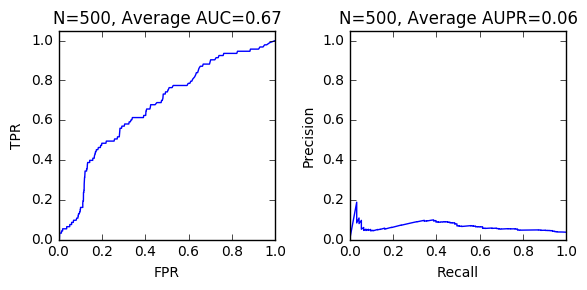

1 : 500------------------------------------


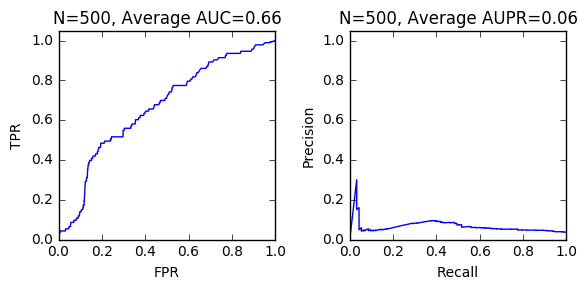

2 : 500------------------------------------


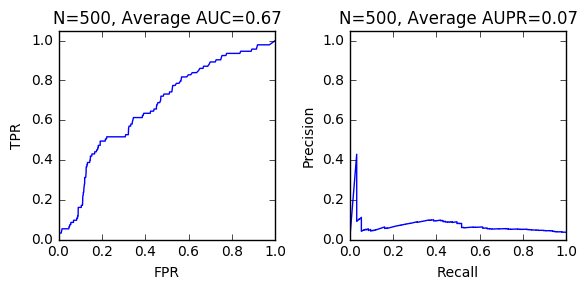

3 : 500------------------------------------


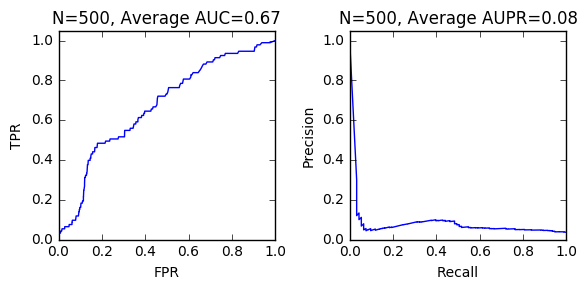

4 : 500------------------------------------


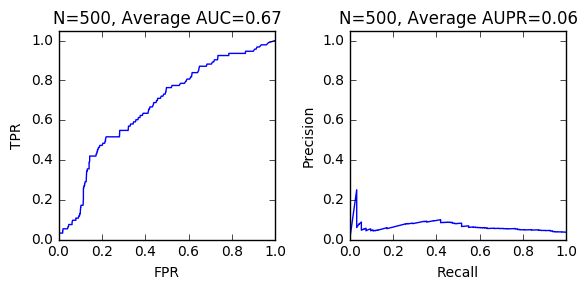

5 : 500------------------------------------


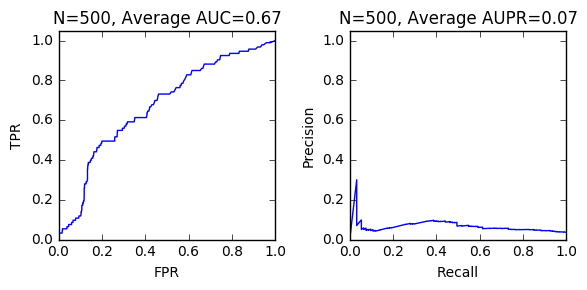

6 : 500------------------------------------


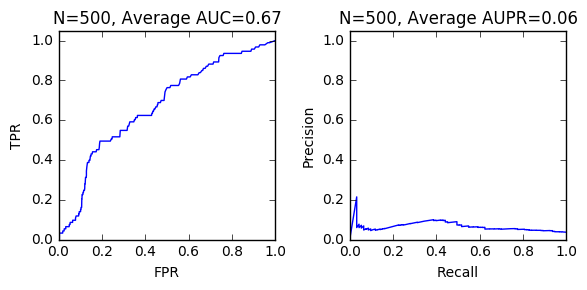

7 : 500------------------------------------


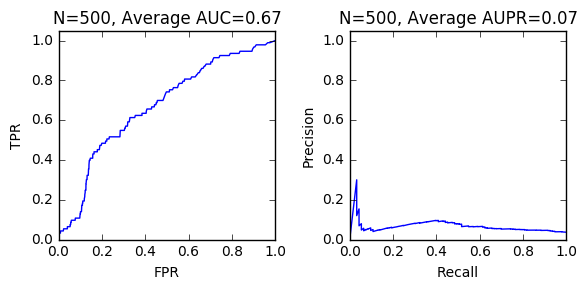

8 : 500------------------------------------


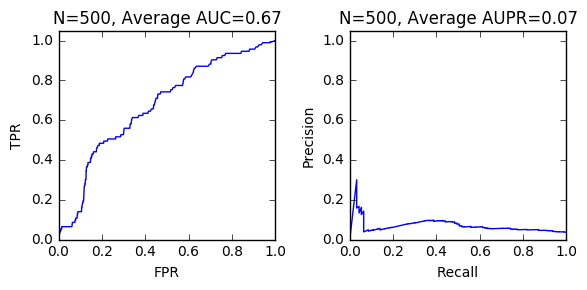

9 : 500------------------------------------


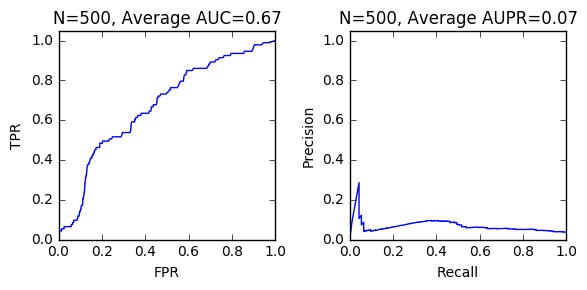

2017-04-04 20:41:14


In [95]:
# no random noise = tn only
li_tns = list()
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/'
with open(path + "0_RF_tn_only_indep.txt", 'w') as fd :
    user_estimator = 500
    for i in range(10):
    #for idx, i in zip(range(10)):
        fd.write("<{} : independent>\r\n".format(i))
        '''idx = random.sample(xrange(0, no_tn_count), tn_neg_count) # no_tn_count의 index에서 tn_count의 갯수만큼 랜덤으로 인덱스를 뽑느다.
        indices.append(idx)
        filtered = no_tn.filter(items = idx, axis=0) # 뽑은 index만큼 filter
        noise_tn = pd.concat([tn,filtered])'''
        
        x_whole_data = tn[tn.columns.values[3:].tolist()].values
        y_whole_data = tn["association"].values
        
        folds_results, draw_results, fp_results = Random_Forest_independent_graph(x_whole_data, y_whole_data, indep_x, indep_y, user_estimator)

        draw_plot([draw_results], folds_results, i, user_estimator)
        li_tns.append(predicted_results(fp_results))
        write_output(fd, folds_results, i, user_estimator)
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df_predicted_results_tn = pd.concat(li_tns)

In [226]:
f = open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/0_RF_tn_only_indep_index.txt", 'w')
for item in indices:
    f.write("%s\n" % item)
f.close()

2017-04-04 20:31:22
0 : 500------------------------------------


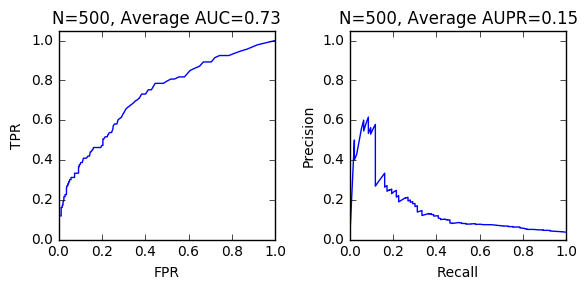

1 : 500------------------------------------


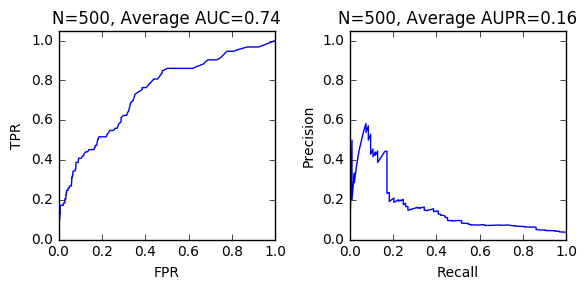

2 : 500------------------------------------


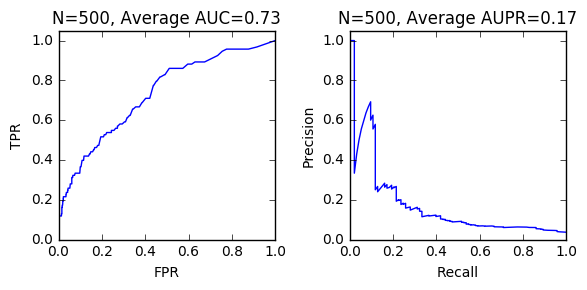

3 : 500------------------------------------


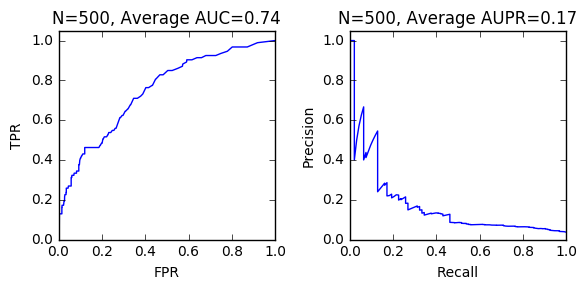

4 : 500------------------------------------


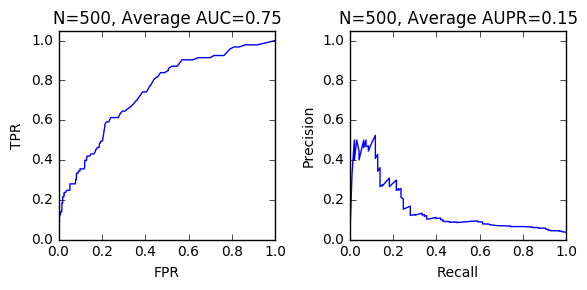

5 : 500------------------------------------


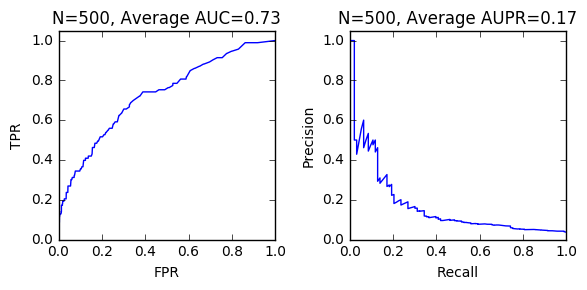

6 : 500------------------------------------


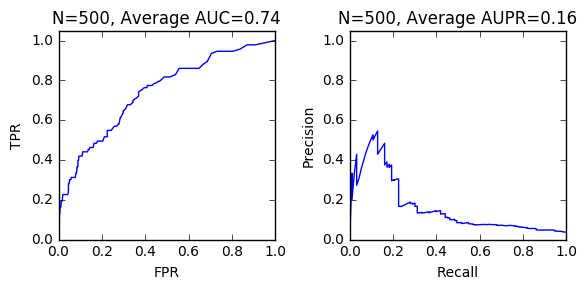

7 : 500------------------------------------


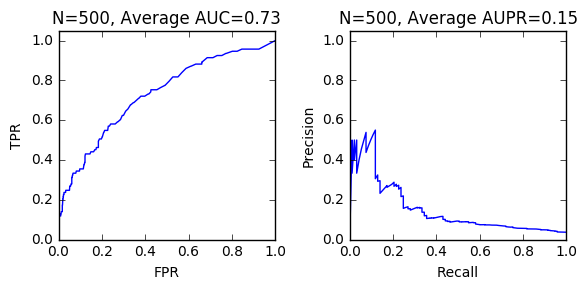

8 : 500------------------------------------


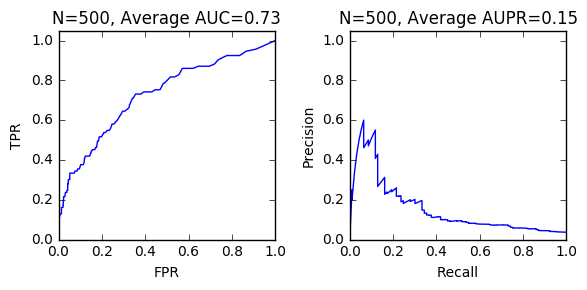

9 : 500------------------------------------


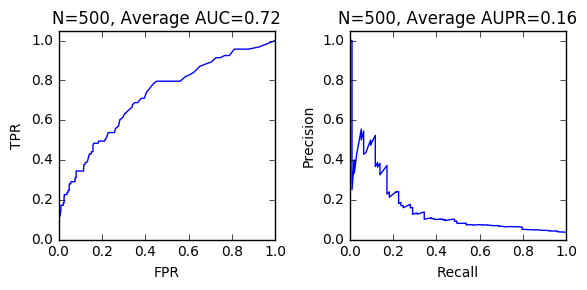

2017-04-04 20:34:03


In [92]:
# pick random noise by 1:1 
indices_1 = list()
li_noise1 = list()
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/'
with open(path + "1_RF_noise_indep_1by1.txt", 'w') as fd :
    user_estimator = 500
    for i in range(10):
        fd.write("<{} : independent>\r\n".format(i))
        idx = random.sample(xrange(0, no_tn_count), tn_neg_count) # no_tn_count의 index에서 tn_count의 갯수만큼 랜덤으로 인덱스를 뽑느다.
        indices_1.append(idx)
        filtered = no_tn.filter(items = idx, axis=0) # 뽑은 index만큼 filter
        noise_tn = pd.concat([tn,filtered])

        x_whole_data = noise_tn[noise_tn.columns.values[3:].tolist()].values
        y_whole_data = noise_tn["association"].values
        
        folds_results, draw_results, fp_results = Random_Forest_independent_graph(x_whole_data, y_whole_data, indep_x, indep_y, user_estimator)
        draw_plot([draw_results], folds_results, i, user_estimator)
        li_noise1.append(predicted_results(fp_results))
        write_output(fd, folds_results, i, user_estimator)
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df_predicted_results_noise_1 = pd.concat(li_noise1)  

In [227]:
f = open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/1_RF_noise_indep_1by1_index.txt", 'w')
for item in indices_1:
    f.write("%s\n" % item)
f.close()

2017-04-04 20:41:14
0 : 500------------------------------------


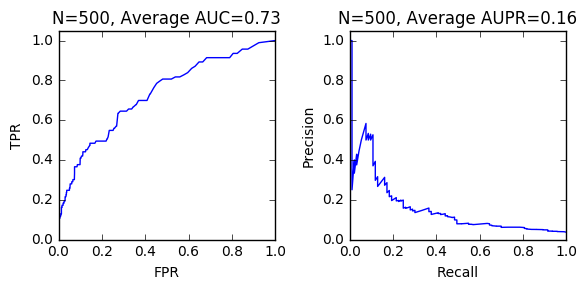

1 : 500------------------------------------


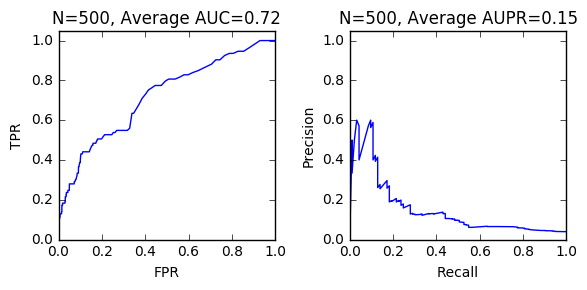

2 : 500------------------------------------


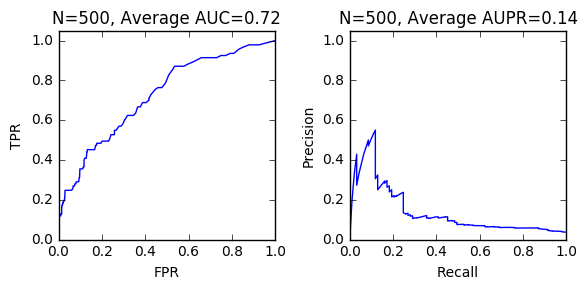

3 : 500------------------------------------


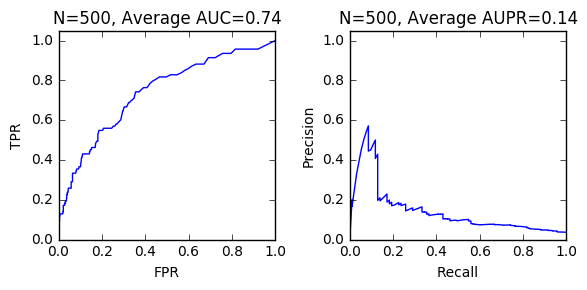

4 : 500------------------------------------


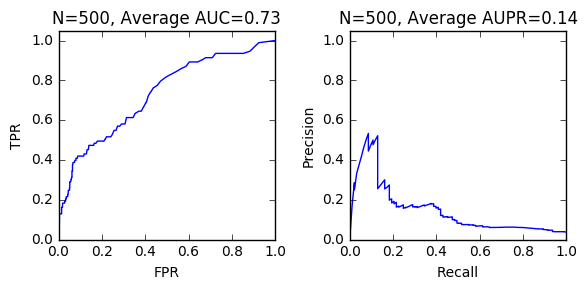

5 : 500------------------------------------


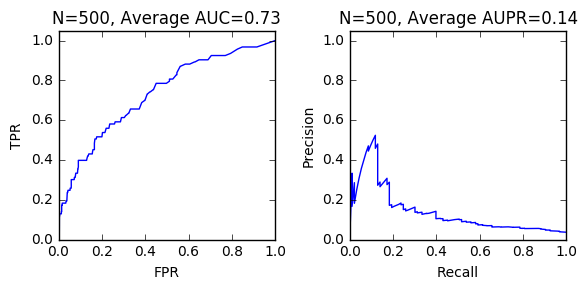

6 : 500------------------------------------


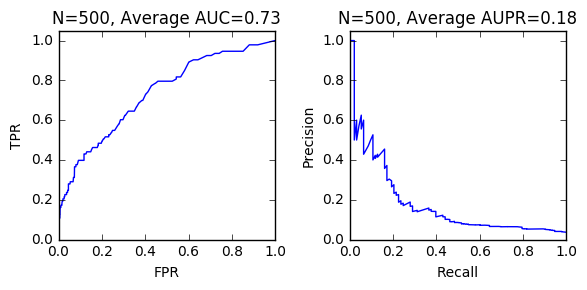

7 : 500------------------------------------


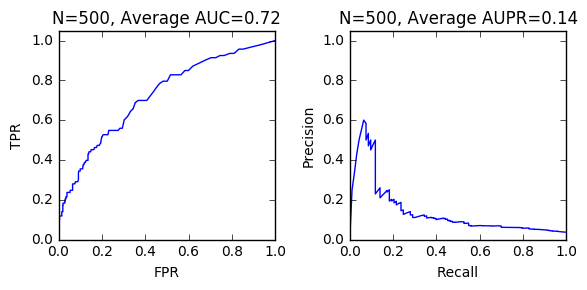

8 : 500------------------------------------


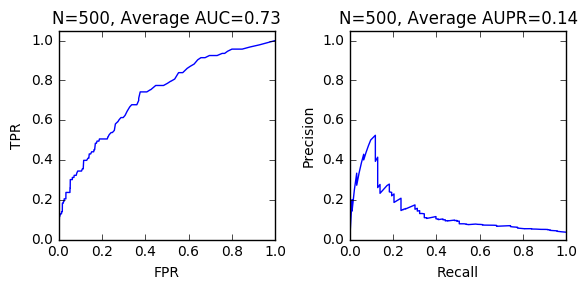

9 : 500------------------------------------


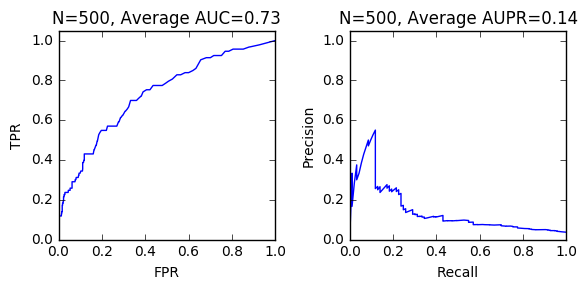

2017-04-04 20:43:36


In [96]:
# pick random noise by 1:0.8
#indices_08 = list()
li_noise_08 = list()
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/'
with open(path + "2_RF_noise_indep_1by0.8.txt", 'w') as fd :
    user_estimator = 500
    for idx, i in zip(indices_08, range(10)):
    #for i in range(10):
        fd.write("<{} : independent>\r\n".format(i))
        
        '''idx = random.sample(xrange(0, no_tn_count), int(tn_neg_count*0.8)) # no_tn_count의 index에서 tn_count의 갯수만큼 랜덤으로 인덱스를 뽑느다.
        indices_08.append(idx)'''
        filtered = no_tn.filter(items = idx, axis=0) # 뽑은 index만큼 filter
        noise_tn = pd.concat([tn,filtered])

        x_whole_data = noise_tn[noise_tn.columns.values[3:].tolist()].values
        y_whole_data = noise_tn["association"].values
        
        folds_results, draw_results, fp_results = Random_Forest_independent_graph(x_whole_data, y_whole_data, indep_x, indep_y, user_estimator)
        draw_plot([draw_results], folds_results, i, user_estimator)
        li_noise_08.append(predicted_results(fp_results))
        write_output(fd, folds_results, i, user_estimator)
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df_predicted_results_noise_08 = pd.concat(li_noise_08)

In [228]:
f = open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/2_RF_noise_indep_1by0.8_index.txt", 'w')
for item in indices_08:
    f.write("%s\n" % item)
f.close()

2017-04-04 20:43:36
0 : 500------------------------------------


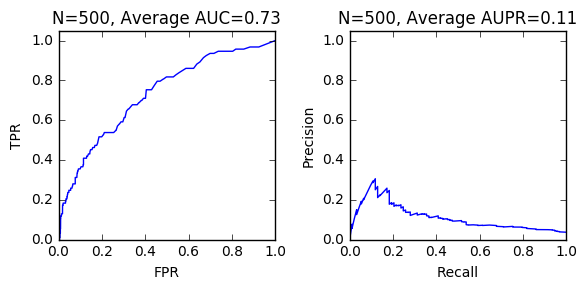

1 : 500------------------------------------


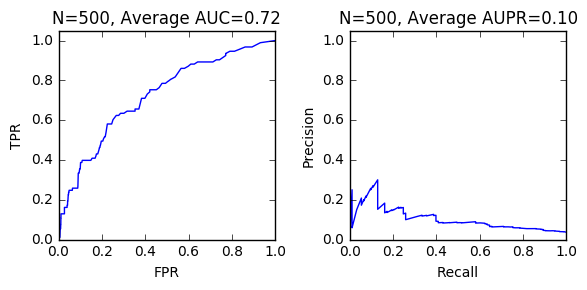

2 : 500------------------------------------


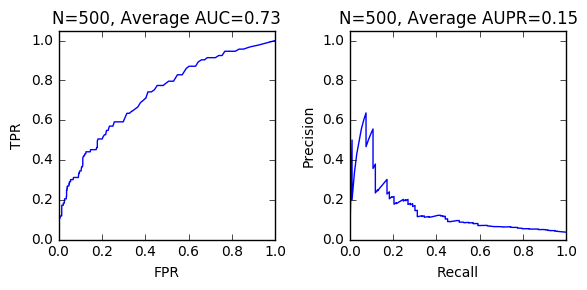

3 : 500------------------------------------


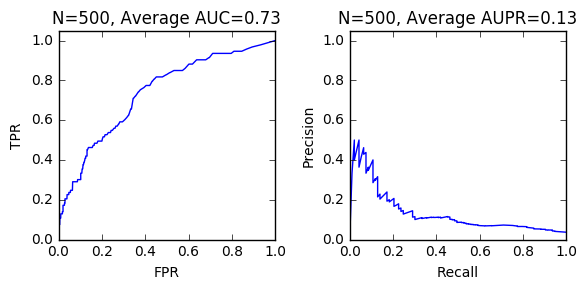

4 : 500------------------------------------


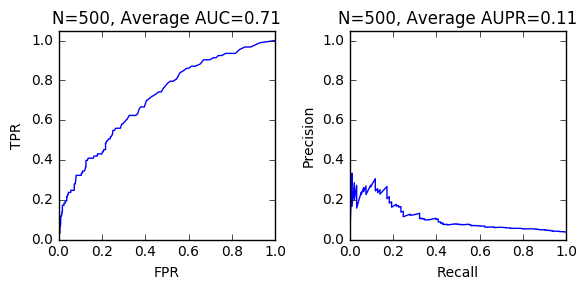

5 : 500------------------------------------


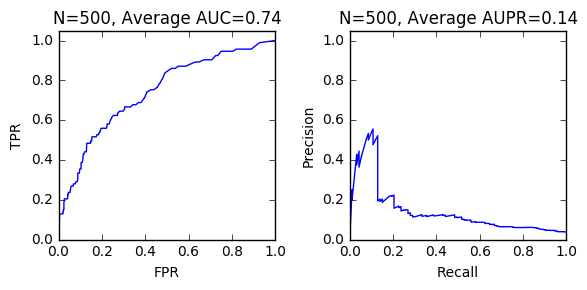

6 : 500------------------------------------


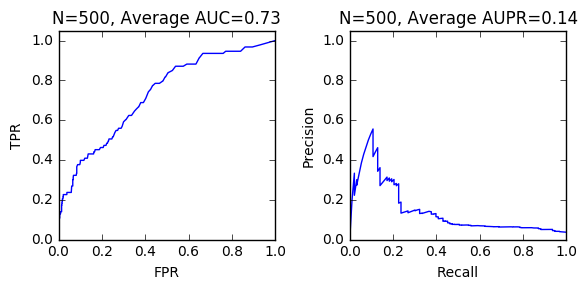

7 : 500------------------------------------


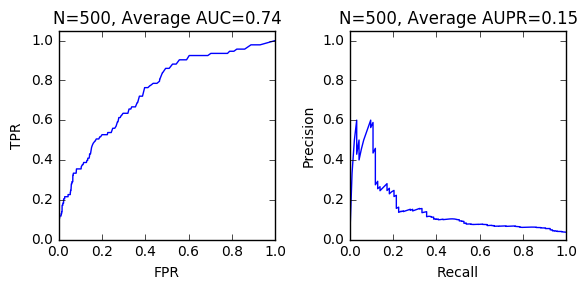

8 : 500------------------------------------


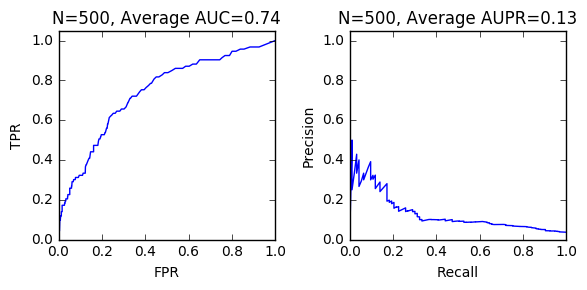

9 : 500------------------------------------


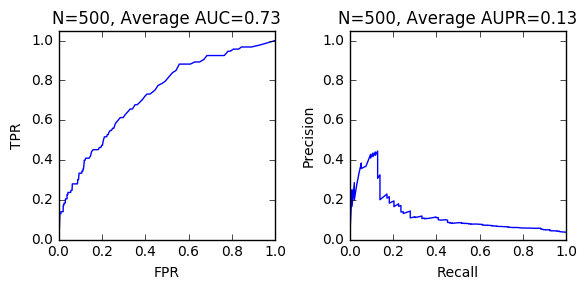

2017-04-04 20:45:41


In [97]:
# pick random noise by 1:0.6
#indices_06 = list()
li_noise_06 = list()
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/'
with open(path + "3_RF_noise_indep_1by0.6.txt", 'w') as fd :
    user_estimator = 500
    #for i in range(10):
    for idx, i in zip(indices_06, range(10)):
        fd.write("<{} : independent>\r\n".format(i))
        
        '''idx = random.sample(xrange(0, no_tn_count), int(tn_neg_count*0.6)) # no_tn_count의 index에서 tn_count의 갯수만큼 랜덤으로 인덱스를 뽑느다.
        indices_06.append(idx)'''
        filtered = no_tn.filter(items = idx, axis=0) # 뽑은 index만큼 filter
        noise_tn = pd.concat([tn,filtered])

        x_whole_data = noise_tn[noise_tn.columns.values[3:].tolist()].values
        y_whole_data = noise_tn["association"].values
        
        folds_results, draw_results, fp_results = Random_Forest_independent_graph(x_whole_data, y_whole_data, indep_x, indep_y, user_estimator)
        draw_plot([draw_results], folds_results, i, user_estimator)
        li_noise_06.append(predicted_results(fp_results))
        write_output(fd, folds_results, i, user_estimator)
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df_predicted_results_noise_06 = pd.concat(li_noise_06)

In [229]:
f = open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/3_RF_noise_indep_1by0.6_index.txt", 'w')
for item in indices_06:
    f.write("%s\n" % item)
f.close()

2017-04-04 20:50:22
0 : 500------------------------------------


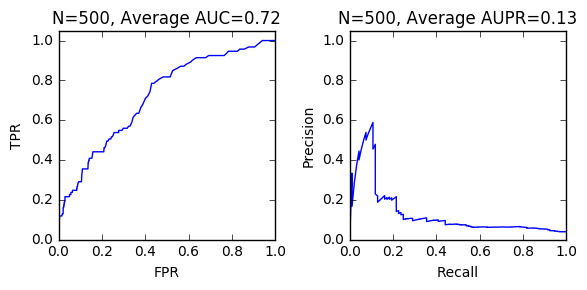

1 : 500------------------------------------


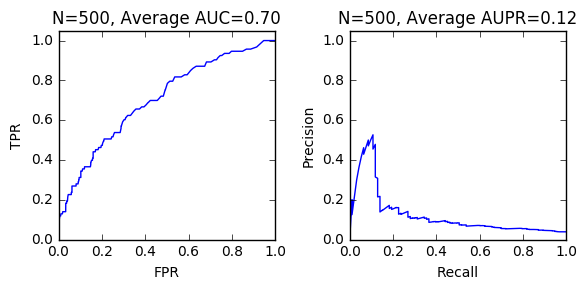

2 : 500------------------------------------


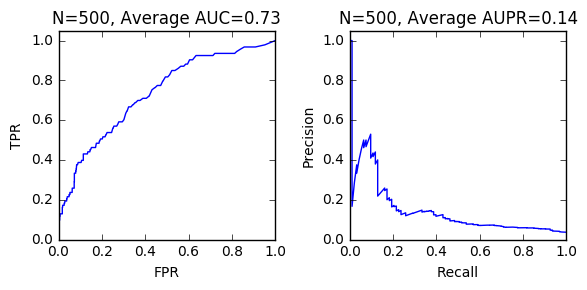

3 : 500------------------------------------


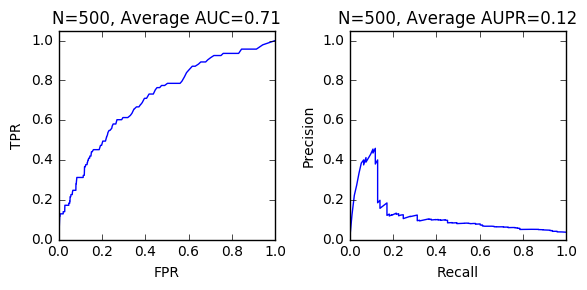

4 : 500------------------------------------


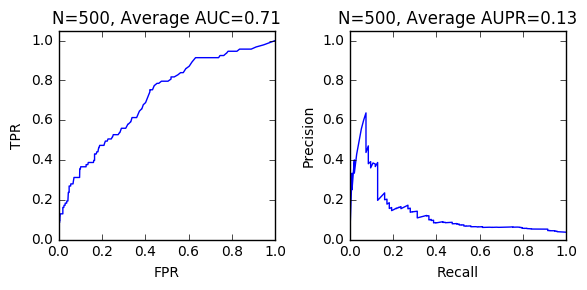

5 : 500------------------------------------


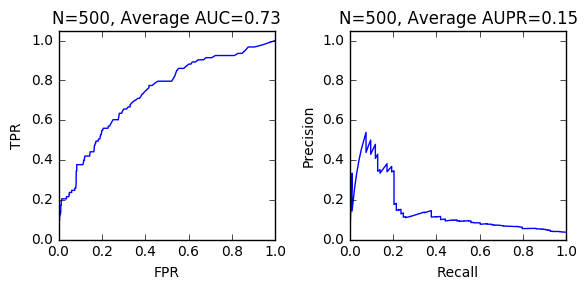

6 : 500------------------------------------


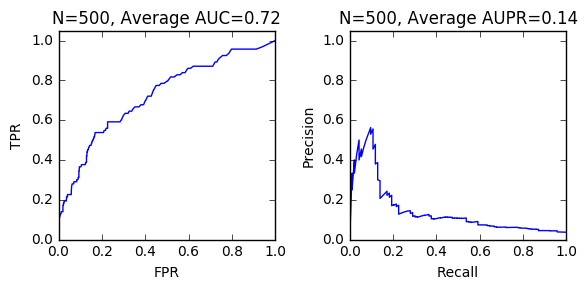

7 : 500------------------------------------


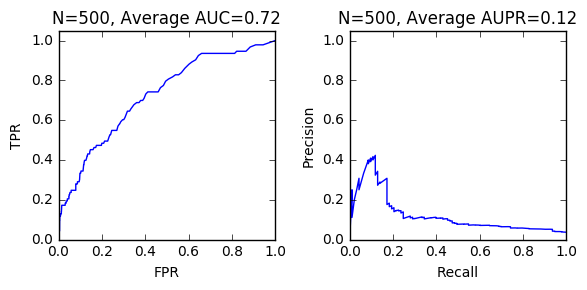

8 : 500------------------------------------


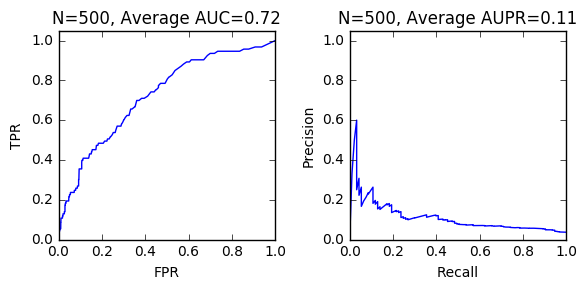

9 : 500------------------------------------


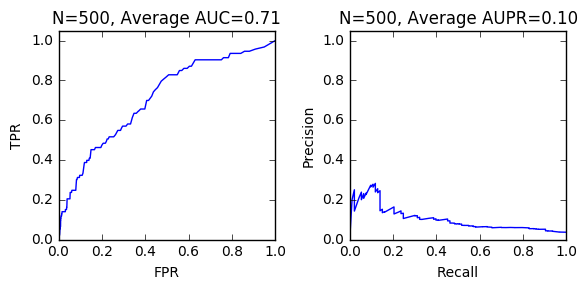

2017-04-04 20:52:12


In [99]:
# pick random noise by 1:0.4
#indices_04 = list()
li_noise_04 = list()
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/'
with open(path + "4_RF_noise_indep_1by0.4.txt", 'w') as fd :
    user_estimator = 500
    #for i in range(10):
    for idx, i in zip(indices_04, range(10)):
        fd.write("<{} : independent>\r\n".format(i))
        
        '''idx = random.sample(xrange(0, no_tn_count), int(tn_neg_count*0.4)) # no_tn_count의 index에서 tn_count의 갯수만큼 랜덤으로 인덱스를 뽑느다.
        indices_04.append(idx)'''
        filtered = no_tn.filter(items = idx, axis=0) # 뽑은 index만큼 filter
        noise_tn = pd.concat([tn,filtered])

        x_whole_data = noise_tn[noise_tn.columns.values[3:].tolist()].values
        y_whole_data = noise_tn["association"].values
        
        folds_results, draw_results, fp_results = Random_Forest_independent_graph(x_whole_data, y_whole_data, indep_x, indep_y, user_estimator)
        draw_plot([draw_results], folds_results, i, user_estimator)
        li_noise_04.append(predicted_results(fp_results))
        write_output(fd, folds_results, i, user_estimator)
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df_predicted_results_noise_04 = pd.concat(li_noise_04)

In [230]:
f = open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/4_RF_noise_indep_1by0.4_index.txt", 'w')
for item in indices_04:
    f.write("%s\n" % item)
f.close()

2017-04-04 20:52:51
0 : 500------------------------------------


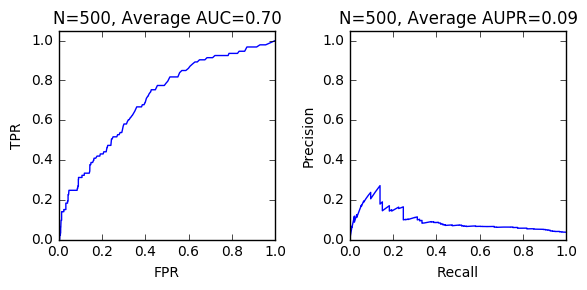

1 : 500------------------------------------


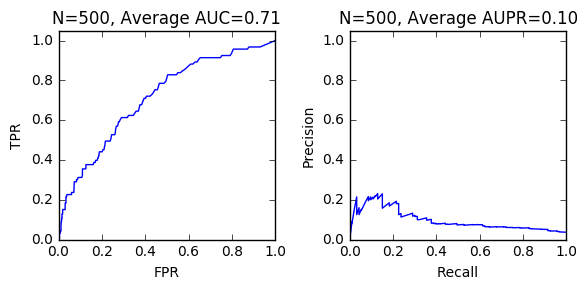

2 : 500------------------------------------


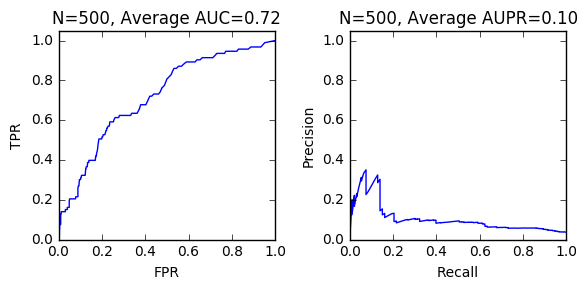

3 : 500------------------------------------


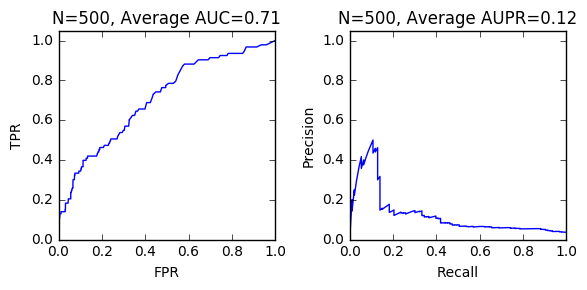

4 : 500------------------------------------


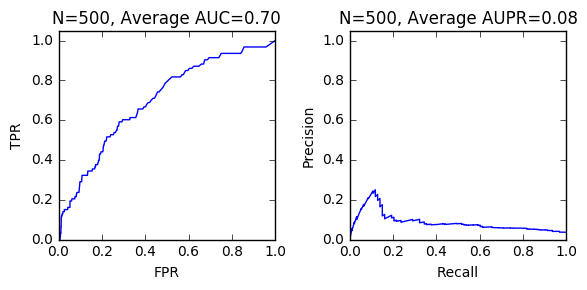

5 : 500------------------------------------


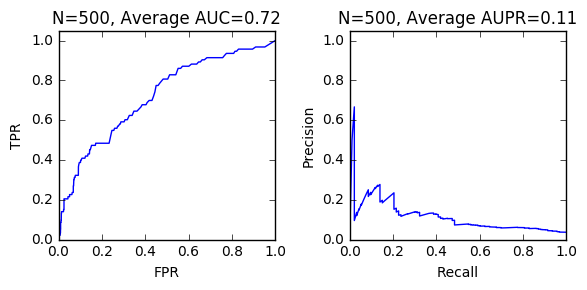

6 : 500------------------------------------


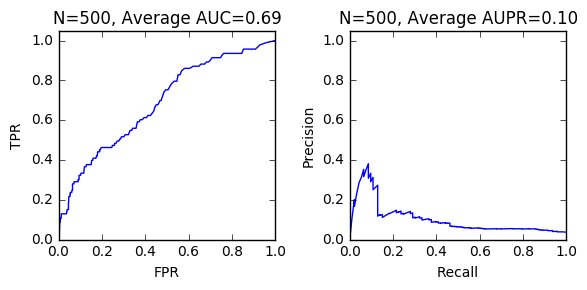

7 : 500------------------------------------


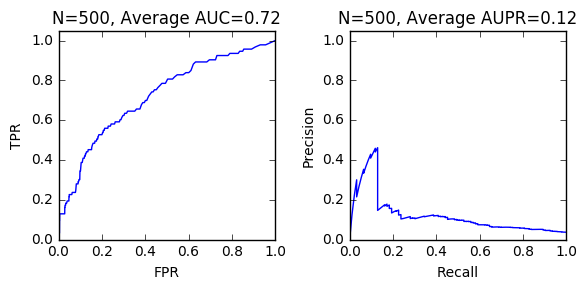

8 : 500------------------------------------


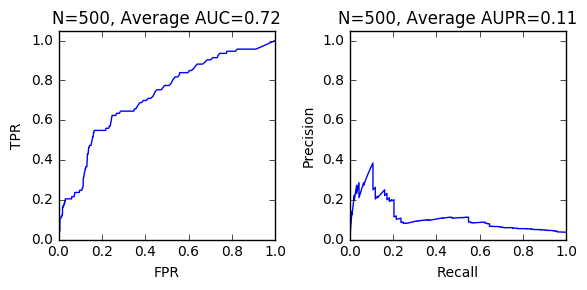

9 : 500------------------------------------


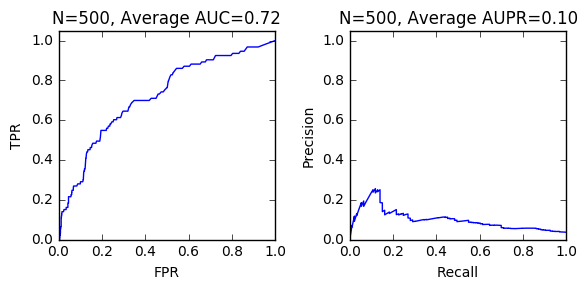

2017-04-04 20:54:21


In [101]:
# pick random noise by 1:0.2
#indices_02 = list()
li_noise_02 = list()
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/'
with open(path + "5_RF_noise_indep_1by0.2.txt", 'w') as fd :
    user_estimator = 500
    #for i in range(10):
    for idx, i in zip(indices_02, range(10)):
        fd.write("<{} : independent>\r\n".format(i))
        
        '''idx = random.sample(xrange(0, no_tn_count), int(tn_neg_count*0.2)) # no_tn_count의 index에서 tn_count의 갯수만큼 랜덤으로 인덱스를 뽑느다.
        indices_02.append(idx)'''
        filtered = no_tn.filter(items = idx, axis=0) # 뽑은 index만큼 filter
        noise_tn = pd.concat([tn,filtered])

        x_whole_data = noise_tn[noise_tn.columns.values[3:].tolist()].values
        y_whole_data = noise_tn["association"].values
        
        folds_results, draw_results, fp_results = Random_Forest_independent_graph(x_whole_data, y_whole_data, indep_x, indep_y, user_estimator)
        draw_plot([draw_results], folds_results, i, user_estimator)
        li_noise_02.append(predicted_results(fp_results))
        write_output(fd, folds_results, i, user_estimator)
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df_predicted_results_noise_02= pd.concat(li_noise_02)

In [231]:
f = open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/5_RF_noise_indep_1by0.2_index.txt", 'w')
for item in indices_02:
    f.write("%s\n" % item)
f.close()

2017-04-04 20:54:21
0 : 500------------------------------------


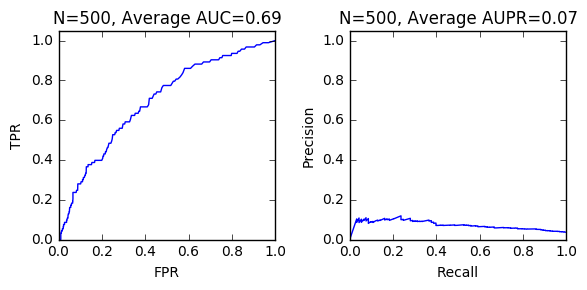

1 : 500------------------------------------


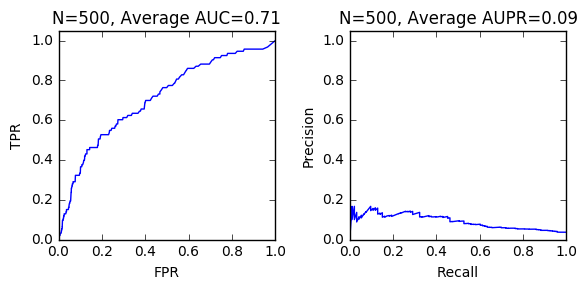

2 : 500------------------------------------


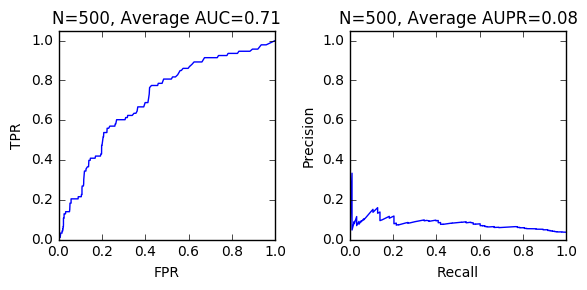

3 : 500------------------------------------


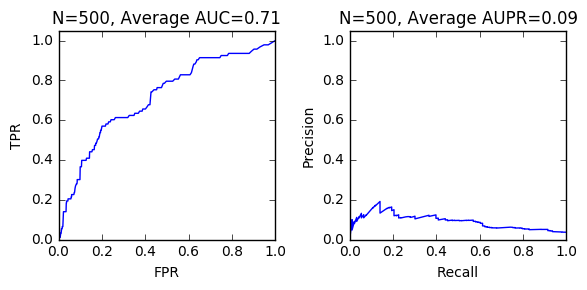

4 : 500------------------------------------


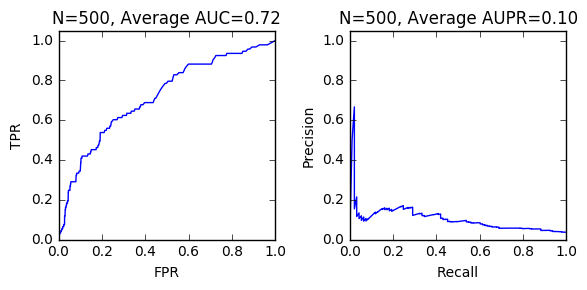

5 : 500------------------------------------


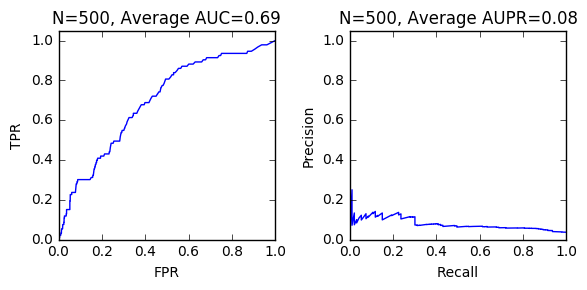

6 : 500------------------------------------


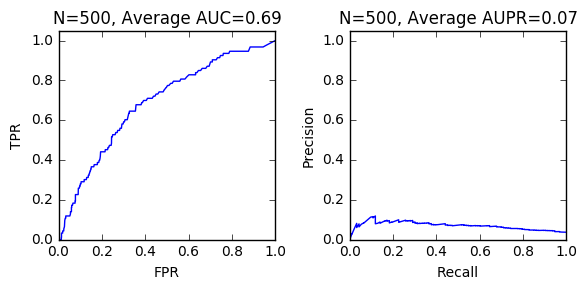

7 : 500------------------------------------


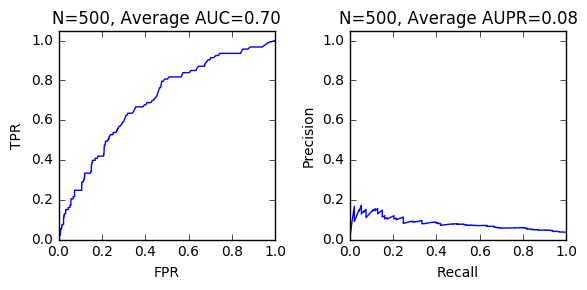

8 : 500------------------------------------


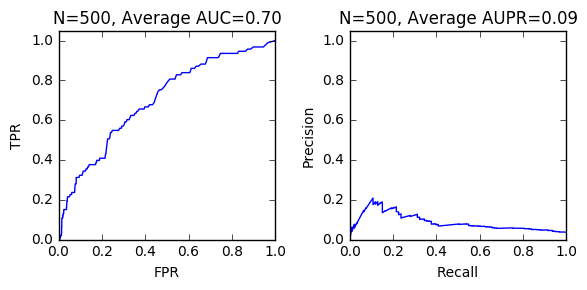

9 : 500------------------------------------


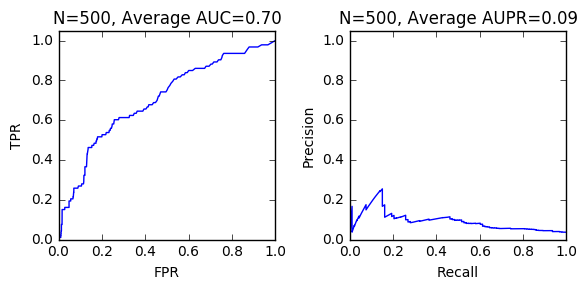

2017-04-04 20:55:44


In [102]:
# pick random noise by 1:0.1
indices_01 = list()
li_noise_01 = list()
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/'
with open(path + "6_RF_noise_indep_1by0.1.txt", 'w') as fd :
    user_estimator = 500
    for i in range(10):
    #for idx, i in zip(indices_01, range(10)):
        fd.write("<{} : independent>\r\n".format(i))
        
        idx = random.sample(xrange(0, no_tn_count), int(tn_neg_count*0.1)) # no_tn_count의 index에서 tn_count의 갯수만큼 랜덤으로 인덱스를 뽑느다.
        indices_01.append(idx)
        filtered = no_tn.filter(items = idx, axis=0) # 뽑은 index만큼 filter
        noise_tn = pd.concat([tn,filtered])

        x_whole_data = noise_tn[noise_tn.columns.values[3:].tolist()].values
        y_whole_data = noise_tn["association"].values
        
        folds_results, draw_results, fp_results = Random_Forest_independent_graph(x_whole_data, y_whole_data, indep_x, indep_y, user_estimator)
        draw_plot([draw_results], folds_results, i, user_estimator)
        li_noise_01.append(predicted_results(fp_results))
        write_output(fd, folds_results, i, user_estimator)
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df_predicted_results_noise_01 = pd.concat(li_noise_01)

In [232]:
f = open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/6_RF_noise_indep_1by0.1_index.txt", 'w')
for item in indices_01:
    f.write("%s\n" % item)
f.close()

In [120]:
print len(df_predicted_results_noise_wh)
print len(df_predicted_results_noise)
print len(df_predicted_results_noise_1)
print len(df_predicted_results_noise_08)
print len(df_predicted_results_noise_06)
print len(df_predicted_results_noise_04)
print len(df_predicted_results_noise_02)
print len(df_predicted_results_noise_01)
print len(df_predicted_results_tn)

25390
25390
25390
25390
25390
25390
25390
25390
25390


In [375]:
path = "/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/"
df_predicted_results_noise.to_csv(path + "0_RF_noise_only_predicted_results.tsv", sep='\t', index=False)
df_predicted_results_noise_1.to_csv(path + "1_RF_noise_1by1_predicted_results.tsv", sep='\t', index=False)
df_predicted_results_noise_08.to_csv(path + "2_RF_noise_1by0.8_predicted_results.tsv", sep='\t', index=False)
df_predicted_results_noise_06.to_csv(path + "3_RF_noise_1by0.6_predicted_results.tsv", sep='\t', index=False)
df_predicted_results_noise_04.to_csv(path + "4_RF_noise_1by0.4_predicted_results.tsv", sep='\t', index=False)
df_predicted_results_noise_02.to_csv(path + "5_RF_noise_1by0.2_predicted_results.tsv", sep='\t', index=False)
df_predicted_results_noise_01.to_csv(path + "6_RF_noise_1by0.1_predicted_results.tsv", sep='\t', index=False)
df_predicted_results_tn.to_csv(path + "0_RF_tn_only_predicted_results.tsv", sep='\t', index=False)

In [131]:
#fp
fp_noise_wh = df_predicted_results_noise_wh[(df_predicted_results_noise_wh.Predicted_label != df_predicted_results_noise_wh.y_true) & (df_predicted_results_noise_wh.Predicted_label == 1)]
fp_noise = df_predicted_results_noise[(df_predicted_results_noise.Predicted_label != df_predicted_results_noise.y_true) & (df_predicted_results_noise.Predicted_label == 1)]
fp_noise_1 = df_predicted_results_noise_1[(df_predicted_results_noise_1.Predicted_label != df_predicted_results_noise_1.y_true) & (df_predicted_results_noise_1.Predicted_label == 1)]
fp_noise_08 = df_predicted_results_noise_08[(df_predicted_results_noise_08.Predicted_label != df_predicted_results_noise_08.y_true) & (df_predicted_results_noise_08.Predicted_label == 1)]
fp_noise_06 = df_predicted_results_noise_06[(df_predicted_results_noise_06.Predicted_label != df_predicted_results_noise_06.y_true) & (df_predicted_results_noise_06.Predicted_label == 1)]
fp_noise_04 = df_predicted_results_noise_04[(df_predicted_results_noise_04.Predicted_label != df_predicted_results_noise_04.y_true) & (df_predicted_results_noise_04.Predicted_label == 1)]
fp_noise_02 = df_predicted_results_noise_02[(df_predicted_results_noise_02.Predicted_label != df_predicted_results_noise_02.y_true) & (df_predicted_results_noise_02.Predicted_label == 1)]
fp_noise_01 = df_predicted_results_noise_01[(df_predicted_results_noise_01.Predicted_label != df_predicted_results_noise_01.y_true) & (df_predicted_results_noise_01.Predicted_label == 1)]
fp_tn = df_predicted_results_tn[(df_predicted_results_tn.Predicted_label != df_predicted_results_tn.y_true) & (df_predicted_results_tn.Predicted_label == 1)]
print len(fp_noise_wh), len(fp_noise_wh.drop_duplicates(['Disease_id', 'Drug_id'])), len(fp_noise_wh['Drug_id'].drop_duplicates()), len(fp_noise_wh['Disease_id'].drop_duplicates())
print len(fp_noise), len(fp_noise.drop_duplicates(['Disease_id', 'Drug_id'])), len(fp_noise['Drug_id'].drop_duplicates()), len(fp_noise['Disease_id'].drop_duplicates())
print len(fp_noise_1), len(fp_noise_1.drop_duplicates(['Disease_id', 'Drug_id'])), len(fp_noise_1['Drug_id'].drop_duplicates()), len(fp_noise_1['Disease_id'].drop_duplicates())
print len(fp_noise_08), len(fp_noise_08.drop_duplicates(['Disease_id', 'Drug_id'])), len(fp_noise_08['Drug_id'].drop_duplicates()), len(fp_noise_08['Disease_id'].drop_duplicates())
print len(fp_noise_06), len(fp_noise_06.drop_duplicates(['Disease_id', 'Drug_id'])), len(fp_noise_06['Drug_id'].drop_duplicates()), len(fp_noise_06['Disease_id'].drop_duplicates())
print len(fp_noise_04), len(fp_noise_04.drop_duplicates(['Disease_id', 'Drug_id'])), len(fp_noise_04['Drug_id'].drop_duplicates()), len(fp_noise_04['Disease_id'].drop_duplicates())
print len(fp_noise_02), len(fp_noise_02.drop_duplicates(['Disease_id', 'Drug_id'])), len(fp_noise_02['Drug_id'].drop_duplicates()), len(fp_noise_02['Disease_id'].drop_duplicates())
print len(fp_noise_01), len(fp_noise_01.drop_duplicates(['Disease_id', 'Drug_id'])), len(fp_noise_01['Drug_id'].drop_duplicates()), len(fp_noise_01['Disease_id'].drop_duplicates())
print len(fp_tn), len(fp_tn.drop_duplicates(['Disease_id', 'Drug_id'])), len(fp_tn['Drug_id'].drop_duplicates()), len(fp_tn['Disease_id'].drop_duplicates())

90 9 8 6
187 71 13 31
122 16 12 10
191 36 15 25
286 47 13 30
366 72 17 32
846 147 32 33
1552 301 45 34
5189 591 61 35


In [376]:
path = "/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/"
fp_noise.to_csv(path + "0_RF_noise_only_fp.tsv", sep='\t', index=False)
fp_noise_1.to_csv(path + "1_RF_noise_1by1_fp.tsv", sep='\t', index=False)
fp_noise_08.to_csv(path + "2_RF_noise_1by0.8_fp.tsv", sep='\t', index=False)
fp_noise_06.to_csv(path + "3_RF_noise_1by0.6_fp.tsv", sep='\t', index=False)
fp_noise_04.to_csv(path + "4_RF_noise_1by0.4_fp.tsv", sep='\t', index=False)
fp_noise_02.to_csv(path + "5_RF_noise_1by0.2_fp.tsv", sep='\t', index=False)
fp_noise_01.to_csv(path + "6_RF_noise_1by0.1_fp.tsv", sep='\t', index=False)
fp_tn.to_csv(path + "0_RF_tn_only_fp.tsv", sep='\t', index=False)

In [132]:
#tp
tp_noise_wh = df_predicted_results_noise_wh[(df_predicted_results_noise_wh.Predicted_label == df_predicted_results_noise_wh.y_true) & (df_predicted_results_noise_wh.Predicted_label == 1)]
tp_noise = df_predicted_results_noise[(df_predicted_results_noise.Predicted_label == df_predicted_results_noise.y_true) & (df_predicted_results_noise.Predicted_label == 1)]
tp_noise_1 = df_predicted_results_noise_1[(df_predicted_results_noise_1.Predicted_label == df_predicted_results_noise_1.y_true) & (df_predicted_results_noise_1.Predicted_label == 1)]
tp_noise_08 = df_predicted_results_noise_08[(df_predicted_results_noise_08.Predicted_label == df_predicted_results_noise_08.y_true) & (df_predicted_results_noise_08.Predicted_label == 1)]
tp_noise_06 = df_predicted_results_noise_06[(df_predicted_results_noise_06.Predicted_label == df_predicted_results_noise_06.y_true) & (df_predicted_results_noise_06.Predicted_label == 1)]
tp_noise_04 = df_predicted_results_noise_04[(df_predicted_results_noise_04.Predicted_label == df_predicted_results_noise_04.y_true) & (df_predicted_results_noise_04.Predicted_label == 1)]
tp_noise_02 = df_predicted_results_noise_02[(df_predicted_results_noise_02.Predicted_label == df_predicted_results_noise_02.y_true) & (df_predicted_results_noise_02.Predicted_label == 1)]
tp_noise_01 = df_predicted_results_noise_01[(df_predicted_results_noise_01.Predicted_label == df_predicted_results_noise_01.y_true) & (df_predicted_results_noise_01.Predicted_label == 1)]
tp_tn = df_predicted_results_tn[(df_predicted_results_tn.Predicted_label == df_predicted_results_tn.y_true) & (df_predicted_results_tn.Predicted_label == 1)]
print len(tp_noise_wh), len(tp_noise_wh.drop_duplicates(['Disease_id', 'Drug_id'])), len(tp_noise_wh['Drug_id'].drop_duplicates()), len(tp_noise_wh['Disease_id'].drop_duplicates())
print len(tp_noise), len(tp_noise.drop_duplicates(['Disease_id', 'Drug_id'])), len(tp_noise['Drug_id'].drop_duplicates()), len(tp_noise['Disease_id'].drop_duplicates())
print len(tp_noise_1), len(tp_noise_1.drop_duplicates(['Disease_id', 'Drug_id'])), len(tp_noise_1['Drug_id'].drop_duplicates()), len(tp_noise_1['Disease_id'].drop_duplicates())
print len(tp_noise_08), len(tp_noise_08.drop_duplicates(['Disease_id', 'Drug_id'])), len(tp_noise_08['Drug_id'].drop_duplicates()), len(tp_noise_08['Disease_id'].drop_duplicates())
print len(tp_noise_06), len(tp_noise_06.drop_duplicates(['Disease_id', 'Drug_id'])), len(tp_noise_06['Drug_id'].drop_duplicates()), len(tp_noise_06['Disease_id'].drop_duplicates())
print len(tp_noise_04), len(tp_noise_04.drop_duplicates(['Disease_id', 'Drug_id'])), len(tp_noise_04['Drug_id'].drop_duplicates()), len(tp_noise_04['Disease_id'].drop_duplicates())
print len(tp_noise_02), len(tp_noise_02.drop_duplicates(['Disease_id', 'Drug_id'])), len(tp_noise_02['Drug_id'].drop_duplicates()), len(tp_noise_02['Disease_id'].drop_duplicates())
print len(tp_noise_01), len(tp_noise_01.drop_duplicates(['Disease_id', 'Drug_id'])), len(tp_noise_01['Drug_id'].drop_duplicates()), len(tp_noise_01['Disease_id'].drop_duplicates())
print len(tp_tn), len(tp_tn.drop_duplicates(['Disease_id', 'Drug_id'])), len(tp_tn['Drug_id'].drop_duplicates()), len(tp_tn['Disease_id'].drop_duplicates())

100 10 9 4
116 16 13 7
111 12 11 5
111 12 11 5
119 12 11 5
122 13 12 6
156 22 17 8
211 34 27 9
457 47 38 15


In [377]:
path = "/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/"
tp_noise.to_csv(path + "0_RF_noise_only_tp.tsv", sep='\t', index=False)
tp_noise_1.to_csv(path + "1_RF_noise_1by1_tp.tsv", sep='\t', index=False)
tp_noise_08.to_csv(path + "2_RF_noise_1by0.8_tp.tsv", sep='\t', index=False)
tp_noise_06.to_csv(path + "3_RF_noise_1by0.6_tp.tsv", sep='\t', index=False)
tp_noise_04.to_csv(path + "4_RF_noise_1by0.4_tp.tsv", sep='\t', index=False)
tp_noise_02.to_csv(path + "5_RF_noise_1by0.2_tp.tsv", sep='\t', index=False)
tp_noise_01.to_csv(path + "6_RF_noise_1by0.1_tp.tsv", sep='\t', index=False)
tp_tn.to_csv(path + "0_RF_tn_only_tp.tsv", sep='\t', index=False)

In [122]:
#tn
tn_noise_wh = df_predicted_results_noise_wh[(df_predicted_results_noise_wh.Predicted_label == df_predicted_results_noise_wh.y_true) & (df_predicted_results_noise_wh.Predicted_label == 0)]
tn_noise = df_predicted_results_noise[(df_predicted_results_noise.Predicted_label == df_predicted_results_noise.y_true) & (df_predicted_results_noise.Predicted_label == 0)]
tn_noise_1 = df_predicted_results_noise_1[(df_predicted_results_noise_1.Predicted_label == df_predicted_results_noise_1.y_true) & (df_predicted_results_noise_1.Predicted_label == 0)]
tn_noise_08 = df_predicted_results_noise_08[(df_predicted_results_noise_08.Predicted_label == df_predicted_results_noise_08.y_true) & (df_predicted_results_noise_08.Predicted_label == 0)]
tn_noise_06 = df_predicted_results_noise_06[(df_predicted_results_noise_06.Predicted_label == df_predicted_results_noise_06.y_true) & (df_predicted_results_noise_06.Predicted_label == 0)]
tn_noise_04 = df_predicted_results_noise_04[(df_predicted_results_noise_04.Predicted_label == df_predicted_results_noise_04.y_true) & (df_predicted_results_noise_04.Predicted_label == 0)]
tn_noise_02 = df_predicted_results_noise_02[(df_predicted_results_noise_02.Predicted_label == df_predicted_results_noise_02.y_true) & (df_predicted_results_noise_02.Predicted_label == 0)]
tn_noise_01 = df_predicted_results_noise_01[(df_predicted_results_noise_01.Predicted_label == df_predicted_results_noise_01.y_true) & (df_predicted_results_noise_01.Predicted_label == 0)]
tn_tn = df_predicted_results_tn[(df_predicted_results_tn.Predicted_label == df_predicted_results_tn.y_true) & (df_predicted_results_tn.Predicted_label == 0)]
print len(tn_noise_wh), len(tn_noise_wh.drop_duplicates(['Disease_id', 'Drug_id'])), len(tn_noise_wh['Drug_id'].drop_duplicates()), len(tn_noise_wh['Disease_id'].drop_duplicates())
print len(tn_noise), len(tn_noise.drop_duplicates(['Disease_id', 'Drug_id'])), len(tn_noise['Drug_id'].drop_duplicates()), len(tn_noise['Disease_id'].drop_duplicates())
print len(tn_noise_1), len(tn_noise_1.drop_duplicates(['Disease_id', 'Drug_id'])), len(tn_noise_1['Drug_id'].drop_duplicates()), len(tn_noise_1['Disease_id'].drop_duplicates())
print len(tn_noise_08), len(tn_noise_08.drop_duplicates(['Disease_id', 'Drug_id'])), len(tn_noise_08['Drug_id'].drop_duplicates()), len(tn_noise_08['Disease_id'].drop_duplicates())
print len(tn_noise_06), len(tn_noise_06.drop_duplicates(['Disease_id', 'Drug_id'])), len(tn_noise_06['Drug_id'].drop_duplicates()), len(tn_noise_06['Disease_id'].drop_duplicates())
print len(tn_noise_04), len(tn_noise_04.drop_duplicates(['Disease_id', 'Drug_id'])), len(tn_noise_04['Drug_id'].drop_duplicates()), len(tn_noise_04['Disease_id'].drop_duplicates())
print len(tn_noise_02), len(tn_noise_02.drop_duplicates(['Disease_id', 'Drug_id'])), len(tn_noise_02['Drug_id'].drop_duplicates()), len(tn_noise_02['Disease_id'].drop_duplicates())
print len(tn_noise_01), len(tn_noise_01.drop_duplicates(['Disease_id', 'Drug_id'])), len(tn_noise_01['Drug_id'].drop_duplicates()), len(tn_noise_01['Disease_id'].drop_duplicates())
print len(tn_tn), len(tn_tn.drop_duplicates(['Disease_id', 'Drug_id'])), len(tn_tn['Drug_id'].drop_duplicates()), len(tn_tn['Disease_id'].drop_duplicates())

24370 2437 73 35
24273 2437 73 35
24338 2437 73 35
24269 2434 73 35
24174 2434 73 35
24094 2433 73 35
23614 2412 73 35
22908 2381 73 35
19271 1992 73 35


In [378]:
path = "/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/"
tn_noise.to_csv(path + "0_RF_noise_only_tn.tsv", sep='\t', index=False)
tn_noise_1.to_csv(path + "1_RF_noise_1by1_tn.tsv", sep='\t', index=False)
tn_noise_08.to_csv(path + "2_RF_noise_1by0.8_tn.tsv", sep='\t', index=False)
tn_noise_06.to_csv(path + "3_RF_noise_1by0.6_tn.tsv", sep='\t', index=False)
tn_noise_04.to_csv(path + "4_RF_noise_1by0.4_tn.tsv", sep='\t', index=False)
tn_noise_02.to_csv(path + "5_RF_noise_1by0.2_tn.tsv", sep='\t', index=False)
tn_noise_01.to_csv(path + "6_RF_noise_1by0.1_tn.tsv", sep='\t', index=False)
tn_tn.to_csv(path + "0_RF_tn_only_tn.tsv", sep='\t', index=False)

In [242]:
#fn
fn_noise_wh = df_predicted_results_noise_wh[(df_predicted_results_noise_wh.Predicted_label != df_predicted_results_noise_wh.y_true) & (df_predicted_results_noise_wh.Predicted_label == 0)]
fn_noise = df_predicted_results_noise[(df_predicted_results_noise.Predicted_label != df_predicted_results_noise.y_true) & (df_predicted_results_noise.Predicted_label == 0)]
fn_noise_1 = df_predicted_results_noise_1[(df_predicted_results_noise_1.Predicted_label != df_predicted_results_noise_1.y_true) & (df_predicted_results_noise_1.Predicted_label == 0)]
fn_noise_08 = df_predicted_results_noise_08[(df_predicted_results_noise_08.Predicted_label != df_predicted_results_noise_08.y_true) & (df_predicted_results_noise_08.Predicted_label == 0)]
fn_noise_06 = df_predicted_results_noise_06[(df_predicted_results_noise_06.Predicted_label != df_predicted_results_noise_06.y_true) & (df_predicted_results_noise_06.Predicted_label == 0)]
fn_noise_04 = df_predicted_results_noise_04[(df_predicted_results_noise_04.Predicted_label != df_predicted_results_noise_04.y_true) & (df_predicted_results_noise_04.Predicted_label == 0)]
fn_noise_02 = df_predicted_results_noise_02[(df_predicted_results_noise_02.Predicted_label != df_predicted_results_noise_02.y_true) & (df_predicted_results_noise_02.Predicted_label == 0)]
fn_noise_01 = df_predicted_results_noise_01[(df_predicted_results_noise_01.Predicted_label != df_predicted_results_noise_01.y_true) & (df_predicted_results_noise_01.Predicted_label == 0)]
fn_tn = df_predicted_results_tn[(df_predicted_results_tn.Predicted_label != df_predicted_results_tn.y_true) & (df_predicted_results_tn.Predicted_label == 0)]
print len(fn_noise_wh), len(fn_noise_wh.drop_duplicates(['Disease_id', 'Drug_id'])), len(fn_noise_wh['Drug_id'].drop_duplicates()), len(fn_noise_wh['Disease_id'].drop_duplicates())
print len(fn_noise), len(fn_noise.drop_duplicates(['Disease_id', 'Drug_id'])), len(fn_noise['Drug_id'].drop_duplicates()), len(fn_noise['Disease_id'].drop_duplicates())
print len(fn_noise_1), len(fn_noise_1.drop_duplicates(['Disease_id', 'Drug_id'])), len(fn_noise_1['Drug_id'].drop_duplicates()), len(fn_noise_1['Disease_id'].drop_duplicates())
print len(fn_noise_08), len(fn_noise_08.drop_duplicates(['Disease_id', 'Drug_id'])), len(fn_noise_08['Drug_id'].drop_duplicates()), len(fn_noise_08['Disease_id'].drop_duplicates())
print len(fn_noise_06), len(fn_noise_06.drop_duplicates(['Disease_id', 'Drug_id'])), len(fn_noise_06['Drug_id'].drop_duplicates()), len(fn_noise_06['Disease_id'].drop_duplicates())
print len(fn_noise_04), len(fn_noise_04.drop_duplicates(['Disease_id', 'Drug_id'])), len(fn_noise_04['Drug_id'].drop_duplicates()), len(fn_noise_04['Disease_id'].drop_duplicates())
print len(fn_noise_02), len(fn_noise_02.drop_duplicates(['Disease_id', 'Drug_id'])), len(fn_noise_02['Drug_id'].drop_duplicates()), len(fn_noise_02['Disease_id'].drop_duplicates())
print len(fn_noise_01), len(fn_noise_01.drop_duplicates(['Disease_id', 'Drug_id'])), len(fn_noise_01['Drug_id'].drop_duplicates()), len(fn_noise_01['Disease_id'].drop_duplicates())
print len(fn_tn), len(fn_tn.drop_duplicates(['Disease_id', 'Drug_id'])), len(fn_tn['Drug_id'].drop_duplicates()), len(fn_tn['Disease_id'].drop_duplicates())

830 83 64 34
814 83 64 34
819 83 64 34
819 83 64 34
811 82 63 34
808 82 63 34
774 81 62 34
719 80 61 34
473 50 39 30


In [379]:
path = "/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/"
fn_noise.to_csv(path + "0_RF_noise_only_fn.tsv", sep='\t', index=False)
fn_noise_1.to_csv(path + "1_RF_noise_1by1_fn.tsv", sep='\t', index=False)
fn_noise_08.to_csv(path + "2_RF_noise_1by0.8_fn.tsv", sep='\t', index=False)
fn_noise_06.to_csv(path + "3_RF_noise_1by0.6_fn.tsv", sep='\t', index=False)
fn_noise_04.to_csv(path + "4_RF_noise_1by0.4_fn.tsv", sep='\t', index=False)
fn_noise_02.to_csv(path + "5_RF_noise_1by0.2_fn.tsv", sep='\t', index=False)
fn_noise_01.to_csv(path + "6_RF_noise_1by0.1_fn.tsv", sep='\t', index=False)
fn_tn.to_csv(path + "0_RF_tn_only_fn.tsv", sep='\t', index=False)

In [223]:
# 매번 tp로 분류되는 애들
df1 = tp_noise[['Disease_id', 'Drug_id']].drop_duplicates()
df2 = tp_noise_1[['Disease_id', 'Drug_id']].drop_duplicates()
df3 = tp_noise_08[['Disease_id', 'Drug_id']].drop_duplicates()
df4 = tp_noise_06[['Disease_id', 'Drug_id']].drop_duplicates()
df5 = tp_noise_04[['Disease_id', 'Drug_id']].drop_duplicates()
df6 = tp_noise_02[['Disease_id', 'Drug_id']].drop_duplicates()
df7 = tp_noise_01[['Disease_id', 'Drug_id']].drop_duplicates()
df8 = tp_tn[['Disease_id', 'Drug_id']].drop_duplicates()
frameList = [df1, df2, df3, df4, df5, df6, df7, df8]
df_inter_tps = reduce(lambda left,right: pd.merge(left,right, on=['Disease_id', 'Drug_id'] ), frameList)
df_union_tps = pd.concat(frameList)[['Disease_id', 'Drug_id']].drop_duplicates()
print len(df_union_tps)
print len(df_inter_tps)

47
12


In [237]:
print len(df_inter_tps), len(df_inter_tps['Drug_id'].drop_duplicates()), len(df_inter_tps['Disease_id'].drop_duplicates())
#print df_inter_tps['Drug_id'].drop_duplicates()
#print df_inter_tps['Disease_id'].drop_duplicates()

12 11 5


In [210]:
# 매번 fp로 분류되는 애들
df1 = fp_noise[['Disease_id', 'Drug_id']].drop_duplicates()
df2 = fp_noise_1[['Disease_id', 'Drug_id']].drop_duplicates()
df3 = fp_noise_08[['Disease_id', 'Drug_id']].drop_duplicates()
df4 = fp_noise_06[['Disease_id', 'Drug_id']].drop_duplicates()
df5 = fp_noise_04[['Disease_id', 'Drug_id']].drop_duplicates()
df6 = fp_noise_02[['Disease_id', 'Drug_id']].drop_duplicates()
df7 = fp_noise_01[['Disease_id', 'Drug_id']].drop_duplicates()
df8 = fp_tn[['Disease_id', 'Drug_id']].drop_duplicates()
frameList = [df1,df2, df3, df4, df5, df6, df7, df8]
df_inter_fps = reduce(lambda left,right: pd.merge(left,right, on=['Disease_id', 'Drug_id'] ), frameList)
df_union_fps = pd.concat(frameList)[['Disease_id', 'Drug_id']].drop_duplicates()
print len(df_inter_fps)
print len(df_union_fps)

14
617


In [238]:
print len(df_inter_fps), len(df_inter_fps['Drug_id'].drop_duplicates()), len(df_inter_fps['Disease_id'].drop_duplicates())
print df_inter_fps['Drug_id'].drop_duplicates()
print df_inter_fps['Disease_id'].drop_duplicates()

14 10 9
0     DB01200
1     DB01586
4     DB00959
6     DB01173
7     DB00313
8     DB00909
9     DB00434
10    DB00620
11    DB00635
12    DB00253
Name: Drug_id, dtype: object
0     168600
1     140600
2     165720
3     607850
6     607501
8     137580
10    212050
12    137750
13    137760
Name: Disease_id, dtype: int64


In [244]:
# 매번 fn로 분류되는 애들
df1 = fn_noise[['Disease_id', 'Drug_id']].drop_duplicates()
df2 = fn_noise_1[['Disease_id', 'Drug_id']].drop_duplicates()
df3 = fn_noise_08[['Disease_id', 'Drug_id']].drop_duplicates()
df4 = fn_noise_06[['Disease_id', 'Drug_id']].drop_duplicates()
df5 = fn_noise_04[['Disease_id', 'Drug_id']].drop_duplicates()
df6 = fn_noise_02[['Disease_id', 'Drug_id']].drop_duplicates()
df7 = fn_noise_01[['Disease_id', 'Drug_id']].drop_duplicates()
df8 = fn_tn[['Disease_id', 'Drug_id']].drop_duplicates()
frameList = [df1,df2, df3, df4, df5, df6, df7, df8]
df_inter_fns = reduce(lambda left,right: pd.merge(left,right, on=['Disease_id', 'Drug_id'] ), frameList)
df_union_fns = pd.concat(frameList)[['Disease_id', 'Drug_id']].drop_duplicates()
print len(df_inter_fns)
print len(df_union_fns)

50
83


In [350]:
# 매번 tn로 분류되는 애들
df1 = tn_noise[['Disease_id', 'Drug_id']].drop_duplicates()
df2 = tn_noise_1[['Disease_id', 'Drug_id']].drop_duplicates()
df3 = tn_noise_08[['Disease_id', 'Drug_id']].drop_duplicates()
df4 = tn_noise_06[['Disease_id', 'Drug_id']].drop_duplicates()
df5 = tn_noise_04[['Disease_id', 'Drug_id']].drop_duplicates()
df6 = tn_noise_02[['Disease_id', 'Drug_id']].drop_duplicates()
df7 = tn_noise_01[['Disease_id', 'Drug_id']].drop_duplicates()
df8 = tn_tn[['Disease_id', 'Drug_id']].drop_duplicates()
frameList = [df1,df2, df3, df4, df5, df6, df7, df8]
df_inter_tns = reduce(lambda left,right: pd.merge(left,right, on=['Disease_id', 'Drug_id'] ), frameList)
df_union_tns = pd.concat(frameList)[['Disease_id', 'Drug_id']].drop_duplicates()
print len(df_inter_tns)
print len(df_union_tns)

1992
2437


In [261]:
# 매번 TP로 분류되는 pair와 매번 FP인 pair, training의 positive 비교

In [257]:
desc_inter_tps = pd.DataFrame()
for index, row in df_inter_tps.iterrows():
    di_id = row['Disease_id']
    dr_id = row['Drug_id']
    temp_df = indep[(indep['drug_id'] == dr_id) & (indep['disease_id'] ==di_id)]
    desc_inter_tps = desc_inter_tps.append(temp_df)

In [259]:
desc_inter_fps = pd.DataFrame()
for index, row in df_inter_fps.iterrows():
    di_id = row['Disease_id']
    dr_id = row['Drug_id']
    temp_df = indep[(indep['drug_id'] == dr_id) & (indep['disease_id'] ==di_id)]
    desc_inter_fps = desc_inter_fps.append(temp_df)

In [343]:
desc_inter_fns = pd.DataFrame()
for index, row in df_inter_fns.iterrows():
    di_id = row['Disease_id']
    dr_id = row['Drug_id']
    temp_df = indep[(indep['drug_id'] == dr_id) & (indep['disease_id'] ==di_id)]
    desc_inter_fns = desc_inter_fns.append(temp_df)

In [351]:
desc_inter_tns = pd.DataFrame()
for index, row in df_inter_tns.iterrows():
    di_id = row['Disease_id']
    dr_id = row['Drug_id']
    temp_df = indep[(indep['drug_id'] == dr_id) & (indep['disease_id'] ==di_id)]
    desc_inter_tns = desc_inter_tns.append(temp_df)

In [382]:
desc_inter_tps.to_csv(path + "desc_inter_tps.tsv", sep='\t')
desc_inter_fps.to_csv(path + "desc_inter_fps.tsv", sep='\t')
desc_inter_tns.to_csv(path + "desc_inter_tns.tsv", sep='\t')
desc_inter_fns.to_csv(path + "desc_inter_fns.tsv", sep='\t')

In [301]:
tps_cnt = pd.DataFrame({'count':desc_inter_tps.sum()[3:]})
fps_cnt = pd.DataFrame({'count':desc_inter_fps.sum()[3:]})

In [320]:
df_pos = whole[whole.association == 1]
pos_cnt = pd.DataFrame({'count':df_pos.sum()[3:]})

In [276]:
odds = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/7_new_association/PREDICT_data/8_2_odds_local_by_feature.tsv")

In [278]:
pos_feature = odds[odds.odds > 0]
neg_feature = odds[odds.odds < 0]

In [285]:
print len(pos_feature)
print len(neg_feature)

149
5216


In [308]:
pos_feature_id = pos_feature['feature']
neg_feature_id = neg_feature['feature']

In [ ]:
# sim 비교
desc_inter_tps
desc_inter_fps
df_pos

In [336]:
# tp와 positive간의 sim
from sklearn.metrics import jaccard_similarity_score
print 'start : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
p_tp = pd.DataFrame()
cnt = 0
for index, row in df_pos.iterrows():
    di_id1 = row['disease_id']
    dr_id1 = row['drug_id']
    desc1 = row[3:].tolist()
    for index2, row2 in desc_inter_tps.iterrows():
        di_id2 = row2['disease_id']
        dr_id2 = row2['drug_id']
        desc2 = row2[3:].tolist()
        
        sim = jaccard_similarity_score(desc1, desc2)
        
        #dataframe형
        temp_df = pd.DataFrame(data= [[dr_id1, di_id1, dr_id2, di_id2, sim]], 
                               columns=['p_drug', 'p_disease','tp_drug','tp_disease','Similarity'])
        p_tp = p_tp.append(temp_df)
        
    cnt = cnt + 1
    if cnt % 100 == 0:
        print 'cnt == {} : '.format(cnt) + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print 'end : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')        

start : 2017-04-05 19:45:10
cnt == 100 : 2017-04-05 19:45:15
cnt == 200 : 2017-04-05 19:45:21
cnt == 300 : 2017-04-05 19:45:26
cnt == 400 : 2017-04-05 19:45:32
cnt == 500 : 2017-04-05 19:45:38
cnt == 600 : 2017-04-05 19:45:43
cnt == 700 : 2017-04-05 19:45:49
cnt == 800 : 2017-04-05 19:45:54
cnt == 900 : 2017-04-05 19:46:00
cnt == 1000 : 2017-04-05 19:46:06
cnt == 1100 : 2017-04-05 19:46:12
cnt == 1200 : 2017-04-05 19:46:18
cnt == 1300 : 2017-04-05 19:46:25
end : 2017-04-05 19:46:29


In [383]:
p_tp.to_csv(path + "sim_positive_tp.tsv", sep='\t', index=False)
p_fp.to_csv(path + "sim_positive_fp.tsv", sep='\t', index=False)
p_fn.to_csv(path + "sim_positive_fn.tsv", sep='\t', index=False)

In [337]:
#fp와 p간의 sim
from sklearn.metrics import jaccard_similarity_score
print 'start : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
p_fp = pd.DataFrame()
cnt = 0
for index, row in df_pos.iterrows():
    di_id1 = row['disease_id']
    dr_id1 = row['drug_id']
    desc1 = row[3:].tolist()
    for index2, row2 in desc_inter_fps.iterrows():
        di_id2 = row2['disease_id']
        dr_id2 = row2['drug_id']
        desc2 = row2[3:].tolist()
        
        sim = jaccard_similarity_score(desc1, desc2)
        
        #dataframe형
        temp_df = pd.DataFrame(data= [[dr_id1, di_id1, dr_id2, di_id2, sim]], 
                               columns=['p_drug', 'p_disease','tp_drug','tp_disease','Similarity'])
        p_fp = p_fp.append(temp_df)
        
    cnt = cnt + 1
    if cnt % 100 == 0:
        print 'cnt == {} : '.format(cnt) + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print 'end : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')        

start : 2017-04-05 19:46:29
cnt == 100 : 2017-04-05 19:46:35
cnt == 200 : 2017-04-05 19:46:41
cnt == 300 : 2017-04-05 19:46:47
cnt == 400 : 2017-04-05 19:46:54
cnt == 500 : 2017-04-05 19:47:00
cnt == 600 : 2017-04-05 19:47:07
cnt == 700 : 2017-04-05 19:47:13
cnt == 800 : 2017-04-05 19:47:20
cnt == 900 : 2017-04-05 19:47:26
cnt == 1000 : 2017-04-05 19:47:33
cnt == 1100 : 2017-04-05 19:47:40
cnt == 1200 : 2017-04-05 19:47:47
cnt == 1300 : 2017-04-05 19:47:55
end : 2017-04-05 19:47:59


In [344]:
# fn와 p간의 sim
from sklearn.metrics import jaccard_similarity_score
print 'start : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
p_fn = pd.DataFrame()
cnt = 0
for index, row in df_pos.iterrows():
    di_id1 = row['disease_id']
    dr_id1 = row['drug_id']
    desc1 = row[3:].tolist()
    for index2, row2 in desc_inter_fns.iterrows():
        di_id2 = row2['disease_id']
        dr_id2 = row2['drug_id']
        desc2 = row2[3:].tolist()
        
        sim = jaccard_similarity_score(desc1, desc2)
        
        #dataframe형
        temp_df = pd.DataFrame(data= [[dr_id1, di_id1, dr_id2, di_id2, sim]], 
                               columns=['p_drug', 'p_disease','fn_drug','fn_disease','Similarity'])
        p_fn = p_fn.append(temp_df)
        
    cnt = cnt + 1
    if cnt % 100 == 0:
        print 'cnt == {} : '.format(cnt) + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print 'end : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')        

start : 2017-04-05 19:55:02
cnt == 100 : 2017-04-05 19:55:26
cnt == 200 : 2017-04-05 19:55:50
cnt == 300 : 2017-04-05 19:56:16
cnt == 400 : 2017-04-05 19:56:42
cnt == 500 : 2017-04-05 19:57:09
cnt == 600 : 2017-04-05 19:57:38
cnt == 700 : 2017-04-05 19:58:07
cnt == 800 : 2017-04-05 19:58:37
cnt == 900 : 2017-04-05 19:59:08
cnt == 1000 : 2017-04-05 19:59:39
cnt == 1100 : 2017-04-05 20:00:12
cnt == 1200 : 2017-04-05 20:00:46
cnt == 1300 : 2017-04-05 20:01:21
end : 2017-04-05 20:01:43


In [348]:
print p_fp['Similarity'].min()
print p_fp['Similarity'].max()
p_fp[p_fp.Similarity ==1]

0.790493942218
1.0


,p_drug,p_disease,fp_drug,fp_disease,Similarity
0,DB01200,168100,DB01200,168600,1.0
0,DB00434,157300,DB00434,607501,1.0
0,DB00313,157300,DB00313,607501,1.0
0,DB00959,140600,DB00959,165720,1.0
0,DB00959,140600,DB00959,607850,1.0
0,DB01173,157300,DB01173,607501,1.0
0,DB00635,157300,DB00635,607501,1.0
0,DB00620,114580,DB00620,212050,1.0


In [349]:
print p_fn['Similarity'].min()
print p_fn['Similarity'].max()
p_fn[p_fn.Similarity ==1]

0.771854613234
0.99962721342


,p_drug,p_disease,fn_drug,fn_disease,Similarity


In [356]:
drdrsim = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/5_new_drug/PREDICT_data/5_gold_drug_drug_sim_predict.tsv")
didisim = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/6_new_disease/10_gold_disease_disease_sim.tsv")

In [362]:
p_fp.index = range(len(p_fp))
p_tp.index = range(len(p_tp))
p_fn.index = range(len(p_fn))

In [358]:
#p_fp
print len(p_fp)
p_fp.head(1)

19068


,p_drug,p_disease,fp_drug,fp_disease,Similarity
0,DB00659,103780,DB01200,168600,0.938677


In [426]:
p_fp['drdrsim'] = -1.0
print len(p_fp)
print 'start : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
cnt = 0
for index, row in p_fp.iterrows():
    p_drug = row['p_drug']
    fp_drug = row['fp_drug']
    sim = drdrsim[(drdrsim.Drug_id1 == p_drug) & (drdrsim.Drug_id2 == fp_drug)]
    if sim.empty:
        continue
    else:
        p_fp.set_value(index, 'drdrsim', sim['Similarity'])
    cnt = cnt + 1
    if cnt % 1000 == 0:
        print 'cnt={} : '.format(cnt) + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print 'end : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')        

19068
start : 2017-04-05 23:31:09
cnt=1000 : 2017-04-05 23:31:49
cnt=2000 : 2017-04-05 23:32:26
cnt=3000 : 2017-04-05 23:33:02
cnt=4000 : 2017-04-05 23:33:40
cnt=5000 : 2017-04-05 23:34:17
cnt=6000 : 2017-04-05 23:34:53
cnt=7000 : 2017-04-05 23:35:29
cnt=8000 : 2017-04-05 23:36:06
cnt=9000 : 2017-04-05 23:36:42
cnt=10000 : 2017-04-05 23:37:18
cnt=11000 : 2017-04-05 23:37:54
cnt=12000 : 2017-04-05 23:38:30
end : 2017-04-05 23:38:39


In [430]:
gold_drug_id = df_pos['drug_id'].drop_duplicates()

In [440]:
indep_drug = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/5_new_drug/PREDICT_data/3_2_indep_drug_se_matrix.tsv", index_col = 0)

In [442]:
gold_drug = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/5_new_drug/PREDICT_data/4_2_gold_se_by_indep_matrix.tsv", index_col = 0)

In [444]:
temp = p_fp[p_fp.drdrsim == -1]
print len(temp)
cnt = 0
print 'start : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
for index, row in temp.iterrows():
    p_drug = row['p_drug']
    new_drug = row['fp_drug']
    desc_p = gold_drug[p_drug].tolist()
    desc_new = indep_drug[new_drug].tolist()
    sim = jaccard_similarity_score(desc_p, desc_new)
    p_fp.set_value(index, 'drdrsim', sim)
    cnt = cnt + 1
    if cnt % 1000 ==0 :
        print 'cnt={} : '.format(cnt) + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print 'end : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')         

6810
start : 2017-04-06 00:03:10
cnt=1000 : 2017-04-06 00:03:31
cnt=2000 : 2017-04-06 00:03:32
cnt=3000 : 2017-04-06 00:03:33
cnt=4000 : 2017-04-06 00:03:34
cnt=5000 : 2017-04-06 00:03:35
cnt=6000 : 2017-04-06 00:03:35
end : 2017-04-06 00:03:36


In [447]:
p_fp['didisim'] = -1.0
print len(p_fp)
print 'start : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
cnt = 0
for index, row in p_fp.iterrows():
    p_disease = row['p_disease']
    fp_disease = row['fp_disease']
    sim = didisim[(didisim.Disease_id1 == p_disease) & (didisim.Disease_id2 == fp_disease)]
    if sim.empty:
        print index, p_disease, fp_disease
        continue
    else:
        p_fp.set_value(index, 'didisim', sim['Similarity'])
    cnt = cnt + 1
    if cnt % 1000 == 0:
        print 'cnt={} : '.format(cnt) + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print 'end : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')        

19068
start : 2017-04-06 00:10:07
cnt=1000 : 2017-04-06 00:10:31
cnt=2000 : 2017-04-06 00:10:32
cnt=3000 : 2017-04-06 00:10:34
cnt=4000 : 2017-04-06 00:10:35
cnt=5000 : 2017-04-06 00:10:36
cnt=6000 : 2017-04-06 00:10:37
cnt=7000 : 2017-04-06 00:10:39
cnt=8000 : 2017-04-06 00:10:40
cnt=9000 : 2017-04-06 00:10:41
cnt=10000 : 2017-04-06 00:10:42
cnt=11000 : 2017-04-06 00:10:43
cnt=12000 : 2017-04-06 00:10:45
cnt=13000 : 2017-04-06 00:10:46
cnt=14000 : 2017-04-06 00:10:47
cnt=15000 : 2017-04-06 00:10:48
cnt=16000 : 2017-04-06 00:10:50
cnt=17000 : 2017-04-06 00:10:51
cnt=18000 : 2017-04-06 00:10:52
cnt=19000 : 2017-04-06 00:10:53
end : 2017-04-06 00:10:54


In [454]:
p_fp.to_csv(path + "sim_positive_fp_drdi.tsv", sep='\t', index=False)

In [458]:
#tp
p_tp['drdrsim'] = -1.0
print len(p_tp)
print 'start : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
cnt = 0
for index, row in p_tp.iterrows():
    p_drug = row['p_drug']
    tp_drug = row['tp_drug']
    sim = drdrsim[(drdrsim.Drug_id1 == p_drug) & (drdrsim.Drug_id2 == tp_drug)]
    if sim.empty:
        desc_p = gold_drug[p_drug].tolist()
        desc_tp = indep_drug[tp_drug].tolist()
        sim_score = jaccard_similarity_score(desc_p, desc_tp)
        p_tp.set_value(index, 'drdrsim', sim_score)
    else:
        p_tp.set_value(index, 'drdrsim', sim['Similarity'])
    cnt = cnt + 1
    if cnt % 1000 == 0:
        print 'cnt={} : '.format(cnt) + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print 'end : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')

p_tp['didisim'] = -1.0
print len(p_tp)
print 'start : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
cnt = 0
for index, row in p_tp.iterrows():
    p_disease = row['p_disease']
    tp_disease = row['tp_disease']
    sim = didisim[(didisim.Disease_id1 == p_disease) & (didisim.Disease_id2 == tp_disease)]
    if sim.empty:
        print index, p_disease, tp_disease
        continue
    else:
        p_tp.set_value(index, 'didisim', sim['Similarity'])
    cnt = cnt + 1
    if cnt % 1000 == 0:
        print 'cnt={} : '.format(cnt) + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print 'end : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')        

16344
start : 2017-04-06 00:54:24
cnt=1000 : 2017-04-06 00:54:47
cnt=2000 : 2017-04-06 00:55:11
cnt=3000 : 2017-04-06 00:55:34
cnt=4000 : 2017-04-06 00:55:57
cnt=5000 : 2017-04-06 00:56:20
cnt=6000 : 2017-04-06 00:56:43
cnt=7000 : 2017-04-06 00:57:06
cnt=8000 : 2017-04-06 00:57:29
cnt=9000 : 2017-04-06 00:57:53
cnt=10000 : 2017-04-06 00:58:16
cnt=11000 : 2017-04-06 00:58:39
cnt=12000 : 2017-04-06 00:59:02
cnt=13000 : 2017-04-06 00:59:26
cnt=14000 : 2017-04-06 00:59:49
cnt=15000 : 2017-04-06 01:00:12
cnt=16000 : 2017-04-06 01:00:35
end : 2017-04-06 01:00:43
16344
start : 2017-04-06 01:00:43
cnt=1000 : 2017-04-06 01:00:45
cnt=2000 : 2017-04-06 01:00:46
cnt=3000 : 2017-04-06 01:00:47
cnt=4000 : 2017-04-06 01:00:48
cnt=5000 : 2017-04-06 01:00:49
cnt=6000 : 2017-04-06 01:00:51
cnt=7000 : 2017-04-06 01:00:52
cnt=8000 : 2017-04-06 01:00:53
cnt=9000 : 2017-04-06 01:00:54
cnt=10000 : 2017-04-06 01:00:55
cnt=11000 : 2017-04-06 01:00:57
cnt=12000 : 2017-04-06 01:00:58
cnt=13000 : 2017-04-06 01:00

In [460]:
p_tp.to_csv(path + "sim_positive_tp_drdi.tsv", sep='\t', index=False)

In [459]:
#fn
p_fn['drdrsim'] = -1.0
print len(p_fn)
print 'start : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
cnt = 0
for index, row in p_fn.iterrows():
    p_drug = row['p_drug']
    fn_drug = row['fn_drug']
    sim = drdrsim[(drdrsim.Drug_id1 == p_drug) & (drdrsim.Drug_id2 == fn_drug)]
    if sim.empty:
        desc_p = gold_drug[p_drug].tolist()
        desc_fn = indep_drug[fn_drug].tolist()
        sim_score = jaccard_similarity_score(desc_p, desc_fn)
        p_fn.set_value(index, 'drdrsim', sim_score)
    else:
        p_fn.set_value(index, 'drdrsim', sim['Similarity'])
    cnt = cnt + 1
    if cnt % 10000 == 0:
        print 'cnt={} : '.format(cnt) + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print 'end : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')

p_fn['didisim'] = -1.0
print len(p_fn)
print 'start : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
cnt = 0
for index, row in p_fn.iterrows():
    p_disease = row['p_disease']
    fn_disease = row['fn_disease']
    sim = didisim[(didisim.Disease_id1 == p_disease) & (didisim.Disease_id2 == fn_disease)]
    if sim.empty:
        print index, p_disease, fn_disease
        continue
    else:
        p_fn.set_value(index, 'didisim', sim['Similarity'])
    cnt = cnt + 1
    if cnt % 10000 == 0:
        print 'cnt={} : '.format(cnt) + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print 'end : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')        

68100
start : 2017-04-06 01:01:03
cnt=10000 : 2017-04-06 01:05:00
cnt=20000 : 2017-04-06 01:08:54
cnt=30000 : 2017-04-06 01:12:49
cnt=40000 : 2017-04-06 01:16:46
cnt=50000 : 2017-04-06 01:20:43
cnt=60000 : 2017-04-06 01:24:36
end : 2017-04-06 01:27:45
68100
start : 2017-04-06 01:27:46
cnt=10000 : 2017-04-06 01:28:14
cnt=20000 : 2017-04-06 01:28:27
cnt=30000 : 2017-04-06 01:28:38
cnt=40000 : 2017-04-06 01:28:50
cnt=50000 : 2017-04-06 01:29:02
cnt=60000 : 2017-04-06 01:29:14
end : 2017-04-06 01:29:24


In [461]:
p_fn.to_csv(path + "sim_positive_fn_drdi.tsv", sep='\t', index=False)

In [2]:
path = "/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/PREDICT_data/noise/"
p_fp = pd.read_table(path + "sim_positive_fp_drdi.tsv")
p_fn = pd.read_table(path + "sim_positive_fn_drdi.tsv")
p_tp = pd.read_table(path + "sim_positive_tp_drdi.tsv")

In [17]:
print p_fp['Similarity'].mean()
print p_fp['Similarity'].min()
print p_fp['Similarity'].max()
print p_fp['Similarity'].std()
print "-----------------------"
print p_fn['Similarity'].mean()
print p_fn['Similarity'].min()
print p_fn['Similarity'].std()
print "-----------------------"
print p_tp['Similarity'].mean()
print p_tp['Similarity'].max()
print p_tp['Similarity'].std()

0.924563523181
0.790493942218
1.0
0.0276277008728
-----------------------
0.918122179296
0.771854613234
0.0282107175791
-----------------------
0.905130422843
1.0
0.0330572784145


In [3]:
import scipy.stats as stats

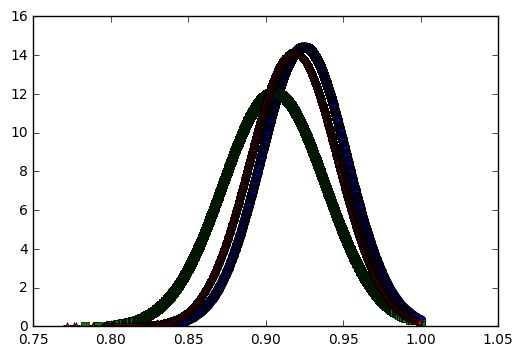

In [38]:
h1 = p_fp['Similarity'].sort_values()
fit1 = stats.norm.pdf(h1, p_fp['Similarity'].mean(), p_fp['Similarity'].std())
plt.plot(h1,fit1, '-o', color = 'b')
#plt.hist(h,normed=True)

h2 = p_tp['Similarity'].sort_values()
fit2 = stats.norm.pdf(h2, p_tp['Similarity'].mean(), p_tp['Similarity'].std())
plt.plot(h2,fit2, '-s', color = 'g')
#plt.hist(h,normed=True)

h3 = p_fn['Similarity'].sort_values()
fit3 = stats.norm.pdf(h3, p_fn['Similarity'].mean(), p_fn['Similarity'].std())
plt.plot(h3,fit3, '-*', color = 'r')
#plt.hist(h,normed=True)

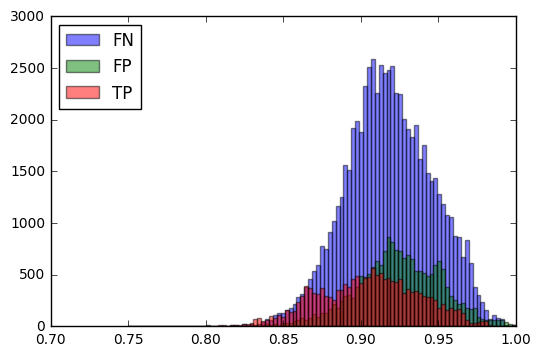

In [21]:
from matplotlib import pyplot
bins = np.linspace(0.75,1,100)

h3 = p_fn['Similarity'].sort_values()
pyplot.hist(h3, bins, alpha=0.5, label = 'FN')
#pyplot.hist(h3, alpha=0.5, label = 'FN')

h1 = p_fp['Similarity'].sort_values()
pyplot.hist(h1,bins, alpha=0.5, label = 'FP')
#pyplot.hist(h1, alpha=0.5, label = 'FP')

h2 = p_tp['Similarity'].sort_values()
pyplot.hist(h2, bins, alpha=0.5, label = 'TP')
#pyplot.hist(h2, alpha=0.5, label = 'TP')

pyplot.legend(loc='upper left')

In [16]:
print p_fp['drdrsim'].mean()print p_fp['drdrsim'].min()
print p_fp['drdrsim'].max()
print p_fp['drdrsim'].std()
print "-----------------------"
print p_fn['drdrsim'].mean()
print p_fn['drdrsim'].min()
print p_fn['drdrsim'].max()
print p_fn['drdrsim'].std()
print "-----------------------"
print p_tp['drdrsim'].mean()
print p_tp['drdrsim'].max()
print p_tp['drdrsim'].min()
print p_tp['drdrsim'].std()

0.839745479929
0.576464208243
1.0
0.0703226899238
-----------------------
0.81419537429
0.54284164859
1.0
0.0667674350434
-----------------------
0.788446581789
1.0
0.565075921909
0.0804514470043


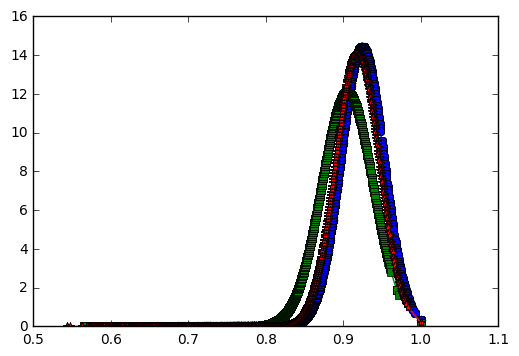

In [36]:
h1 = p_fp['drdrsim'].sort_values()
fit1 = stats.norm.pdf(h1, p_fp['Similarity'].mean(), p_fp['Similarity'].std())
plt.plot(h1,fit1, '-o', color = 'b')
#plt.hist(h,normed=True)

h2 = p_tp['drdrsim'].sort_values()
fit2 = stats.norm.pdf(h2, p_tp['Similarity'].mean(), p_tp['Similarity'].std())
plt.plot(h2,fit2, '-s', color = 'g')#사각형
#plt.hist(h,normed=True)

h3 = p_fn['drdrsim'].sort_values()
fit3 = stats.norm.pdf(h3, p_fn['Similarity'].mean(), p_fn['Similarity'].std())
plt.plot(h3,fit3, '-*', color = 'r') #별
#plt.hist(h,normed=True)

In [24]:
print len(p_fn)
print len(p_fp)
print len(p_tp)
p_fn.head()

68100
19068
16344


,p_drug,p_disease,fn_drug,fn_disease,Similarity,drdrsim,didisim
0,DB00659,103780,DB01200,102300,0.956198,0.901302,0.984947
1,DB00659,103780,DB00575,103780,0.921528,0.771692,1.000000
2,DB00659,103780,DB00280,115195,0.944455,0.873102,0.981823
3,DB00659,103780,DB00343,115195,0.944082,0.872017,0.981823
4,DB00659,103780,DB01100,137580,0.954520,0.892625,0.986936


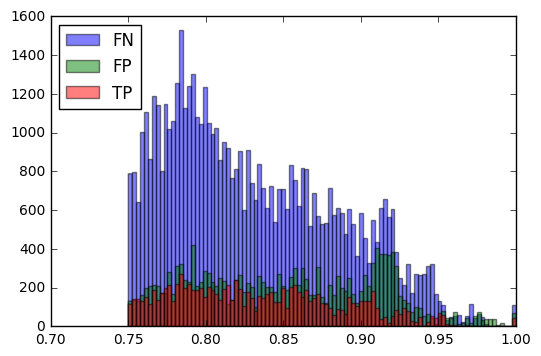

In [22]:
bins = np.linspace(0.75,1,100)

h3 = p_fn['drdrsim'].sort_values()
pyplot.hist(h3, bins, alpha=0.5, label = 'FN')
#pyplot.hist(h3, alpha=0.5, label = 'FN')

h1 = p_fp['drdrsim'].sort_values()
pyplot.hist(h1,bins, alpha=0.5, label = 'FP')
#pyplot.hist(h1, alpha=0.5, label = 'FP')

h2 = p_tp['drdrsim'].sort_values()
pyplot.hist(h2, bins, alpha=0.5, label = 'TP')
#pyplot.hist(h2, alpha=0.5, label = 'TP')

pyplot.legend(loc='upper left')

In [15]:
print p_fp['didisim'].mean()
print p_fp['didisim'].min()
print p_fp['didisim'].max()
print p_fp['didisim'].std()
print "-----------------------"
print p_fn['didisim'].mean()
print p_fn['didisim'].min()
print p_fn['didisim'].max()
print p_fn['didisim'].std()
print "-----------------------"
print p_tp['didisim'].mean()
print p_tp['didisim'].max()
print p_fn['didisim'].std()

0.968983992297
0.877307583073
1.0
0.024392341187
-----------------------
0.972550190779
0.863959102528
1.0
0.02364600737
-----------------------
0.966239483593
1.0
0.02364600737


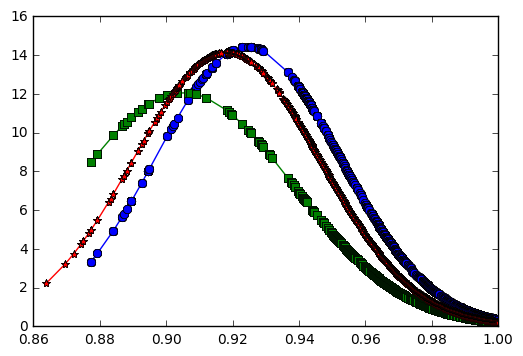

In [37]:
h1 = p_fp['didisim'].sort_values()
fit1 = stats.norm.pdf(h1, p_fp['Similarity'].mean(), p_fp['Similarity'].std())
plt.plot(h1,fit1, '-o', color = 'b')
#plt.hist(h,normed=True)

h2 = p_tp['didisim'].sort_values()
fit2 = stats.norm.pdf(h2, p_tp['Similarity'].mean(), p_tp['Similarity'].std())
plt.plot(h2,fit2, '-s', color = 'g')#사각형
#plt.hist(h,normed=True)

h3 = p_fn['didisim'].sort_values()
fit3 = stats.norm.pdf(h3, p_fn['Similarity'].mean(), p_fn['Similarity'].std())
plt.plot(h3,fit3, '-*', color = 'r') #별
#plt.hist(h,normed=True)

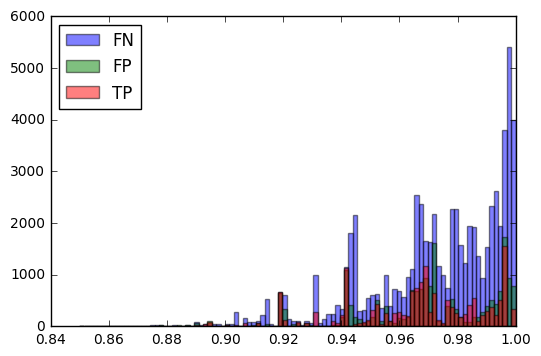

In [26]:
bins = np.linspace(0.85,1,100)

h3 = p_fn['didisim'].sort_values()
pyplot.hist(h3, bins, alpha=0.5, label = 'FN')
#pyplot.hist(h3, alpha=0.5, label = 'FN')

h1 = p_fp['didisim'].sort_values()
pyplot.hist(h1,bins, alpha=0.5, label = 'FP')
#pyplot.hist(h1, alpha=0.5, label = 'FP')

h2 = p_tp['didisim'].sort_values()
pyplot.hist(h2, bins, alpha=0.5, label = 'TP')
#pyplot.hist(h2, alpha=0.5, label = 'TP')

pyplot.legend(loc='upper left')

In [451]:
print drdrsim['Similarity'].min()
print drdrsim['Similarity'].max()
print didisim['Similarity'].min()
print didisim['Similarity'].max()

0.553145336226
1.0
0.826185742687
1.0


In [453]:
print p_fp['drdrsim'].min()
print p_fp['drdrsim'].max()
print p_fp['didisim'].min()
print p_fp['didisim'].max()

0.576464208243
1.0
0.877307583073
1.0


In [26]:
def Random_Forest_independent_graph(X, y, indep_X, indep_y, user_estimator):

    folds_results = dict()
    draw_results = {'fpr':[], 'tpr':[], 'precision_vec':[], 'recall_vec':[]}
    fp_results = dict()
    
    classifier = RandomForestClassifier(n_estimators=user_estimator, n_jobs=-1, class_weight='balanced')
    classifier.fit(X, y)
    indep_y_predicted_proba = classifier.predict_proba(indep_X)
    indep_y_predicted_label = classifier.predict(indep_X)
    fp_results['predicted_proba'] = indep_y_predicted_proba
    fp_results['Predicted_label'] = indep_y_predicted_label
    fp_results['y_true'] = indep_y

    # Accuracy
    indep_acc = classifier.score(indep_X, indep_y)
    folds_results['acc']=indep_acc
    
    # AUC
    indep_auc = roc_auc_score(indep_y, indep_y_predicted_proba[:,1])
    folds_results['auc']=indep_auc
    
    # Sensitivity, Specificity
    indep_sn, indep_sp, support = sensitivity_specificity_support(indep_y, indep_y_predicted_label)
    folds_results['sn']=indep_sn
    folds_results['sp']=indep_sp
    
    # AUPR
    indep_aupr = average_precision_score(indep_y, indep_y_predicted_proba[:,1])
    folds_results['aupr']=indep_aupr
    
    # Precision, Recall
    indep_precision, indep_recall, _, _ = precision_recall_fscore_support(indep_y, indep_y_predicted_label, average = 'binary')
    folds_results['precision']=indep_precision
    folds_results['recall']=indep_recall
    
    # Confusion Matirx
    indep_confusion_matirx = confusion_matrix(indep_y, indep_y_predicted_label)
    folds_results['confusion_matrix']=indep_confusion_matirx
    
    # draw graph
    indep_fpr, indep_tpr, thresholds = roc_curve(indep_y, indep_y_predicted_proba[:, 1], pos_label=1)
    draw_results['fpr'].append(indep_fpr)
    draw_results['tpr'].append(indep_tpr)
        
    indep_precision_vec, indep_recall_vec, _ = precision_recall_curve(indep_y, indep_y_predicted_proba[:, 1])
    draw_results['precision_vec'].append(indep_precision_vec)
    draw_results['recall_vec'].append(indep_recall_vec)

    return folds_results, draw_results, fp_results

In [27]:
def draw_plot(draw_results, final_result, i, user_estimator):
    #colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    colors = ['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna']
    lw = 1
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
    print "{} : {}------------------------------------".format(i, user_estimator)
    for i in draw_results:
        for fpr, tpr in zip(i['fpr'], i['tpr']):
            ax1.plot(fpr, tpr, lw=lw)
        for recall_vec, precision_vec in zip(i['recall_vec'], i['precision_vec']):
            ax2.plot(recall_vec, precision_vec, lw=lw)
    ax1.set_xlabel('FPR')
    ax1.set_ylabel('TPR')
    ax1.set_color_cycle(colors)
    ax1.set_title('N={0}, Average AUC={1:0.2f}'.format(user_estimator, final_result['auc']))
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlim([0.0, 1.0])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_color_cycle(colors)
    ax2.set_title('N={0}, Average AUPR={1:0.2f}'.format(user_estimator, final_result['aupr']))
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlim([0.0, 1.0])
    plt.tight_layout()
    plt.show()

In [28]:
def write_output(fd, write_results, i, user_estimator):
    fd.write("try={}, N={}-------------------------------------------------\r\n".format(i, user_estimator))
    fd.write("Accuracy avg : {}\r\n".format(write_results['acc']))
    fd.write("AUC avg : {}\r\n".format(write_results['auc']))
    fd.write("  Sensitivity avg : {}\r\n".format(write_results['sn']))
    fd.write("  Specificity avg : {}\r\n".format(write_results['sp']))
    fd.write("AUPR avg : {}\r\n".format(write_results['aupr']))
    fd.write("  Precision avg : {}\r\n".format(write_results['precision']))
    fd.write("  Recall avg : {}\r\n".format(write_results['recall']))
    fd.write("confusion amtrix : {}\r\n".format(write_results['confusion_matrix']))